# GRU-Based Mental Health Text Classification with Multiple Embeddings

Denyse Mutoni Uwingeneye

**Model**: Gated Recurrent Unit (GRU)

**Embeddings**: TF-IDF, Word2Vec (Skip-gram), GloVe

## 1. Environment Setup & Imports

In [2]:
# Install required packages
!pip install emoji nltk pandas scikit-learn matplotlib seaborn wordcloud gensim

import os, re, time, emoji, nltk, zipfile, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

# --- High-Resolution Settings ---
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# --- Machine Learning Tools ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             ConfusionMatrixDisplay, precision_recall_fscore_support,
                             accuracy_score, precision_recall_curve)
from sklearn.utils import class_weight

# --- Deep Learning Tools ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (GRU, Dense, Dropout, BatchNormalization,
                                     Bidirectional, Embedding, SpatialDropout1D, Input)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Word Embeddings ---
from gensim.models import Word2Vec

# --- NLTK ---
resources = ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'omw-1.4']
for res in resources:
    nltk.download(res, quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

  Using cached emoji-2.15.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached gensim-4.4.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (8.4 kB)
Using cached emoji-2.15.0-py3-none-any.whl (608 kB)
Using cached gensim-4.4.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (27.9 MB)
✅ All libraries imported successfully!
TensorFlow version: 2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 2. Data Loading & Preprocessing

Using the shared `ClinicalPreprocessor` class for consistent preprocessing across all team members.

In [3]:
class ClinicalPreprocessor:
    """
    Clinical text preprocessor for mental health data.

    Features:
    - URL, mention, and Reddit-specific removal
    - Emoji demojization
    - Contraction expansion
    - Negation handling (preserves semantic meaning)
    - Lemmatization
    - Custom stopword removal (keeps emotionally significant words)
    """
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        # Preserve emotionally significant words
        self.stop_words = set(nltk.corpus.stopwords.words('english')) - {'i', 'me', 'my', 'not', 'no', 'never', 'always'}
        self.contractions = {"i'm": "i am", "i've": "i have", "can't": "cannot", "don't": "do not",
                            "won't": "will not", "shouldn't": "should not", "couldn't": "could not",
                            "wouldn't": "would not", "isn't": "is not", "aren't": "are not"}

    def clean(self, text):
        """Clean and preprocess text for mental health classification."""
        # Convert to lowercase and remove URLs, deleted content, subreddit mentions
        text = re.sub(r'http\S+|\[deleted\]|r/\w+|@\w+', '', str(text).lower())

        # Convert emojis to text descriptions
        text = emoji.demojize(text).replace(":", " ").replace("_", " ")

        # Preserve punctuation patterns (important for sentiment)
        text = re.sub(r'!+', ' ! ', text)
        text = re.sub(r'\?+', ' ? ', text)
        text = re.sub(r'\.{2,}', ' ... ', text)

        # Expand contractions
        for c, e in self.contractions.items():
            text = text.replace(c, e)

        # Reduce repeated characters (e.g., "sooooo" -> "soo")
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)

        # Handle negations (important for sentiment preservation)
        for n in ["not", "no", "never"]:
            text = re.sub(r'\b'+n+r'\s+(\w+)', n+'_\\1', text)

        # Tokenize and lemmatize
        tokens = [self.lemmatizer.lemmatize(w) for w in word_tokenize(text) if w not in self.stop_words]

        # Return tokens longer than 1 character (except 'i')
        return " ".join([t for t in tokens if len(t) > 1 or t == 'i'])

print("✅ ClinicalPreprocessor class defined!")

✅ ClinicalPreprocessor class defined!


In [4]:
# --- Load Dataset ---
# Update this path according to your file location
# For Google Colab: '/content/sample_data/CombinedData.csv'
# For local: 'path/to/CombinedData.csv'

DATA_PATH = '/content/sample_data/CombinedData.csv'  # Update this path

# Load and clean data
df = pd.read_csv(DATA_PATH).dropna(subset=['statement']).reset_index(drop=True)

print(f"📊 Dataset Shape: {df.shape}")
print(f"\n📋 Columns: {df.columns.tolist()}")
print(f"\n📈 Class Distribution:")
print(df['status'].value_counts())

📊 Dataset Shape: (52681, 3)

📋 Columns: ['Unnamed: 0', 'statement', 'status']

📈 Class Distribution:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


In [5]:
# --- Apply Preprocessing ---
cp = ClinicalPreprocessor()

print("⏳ Applying preprocessing... This may take a few minutes.")
start_time = time.time()

df['clean_text'] = df['statement'].apply(cp.clean)

print(f"✅ Preprocessing complete in {time.time() - start_time:.2f} seconds")

# Display preprocessing example
sample_idx = 42
print(f"\n--- PREPROCESSING SAMPLE ---")
print(f"RAW: {df['statement'].iloc[sample_idx][:150]}...")
print(f"CLEANED: {df['clean_text'].iloc[sample_idx][:150]}...")

⏳ Applying preprocessing... This may take a few minutes.
✅ Preprocessing complete in 73.64 seconds

--- PREPROCESSING SAMPLE ---
RAW: Did you ever read it when you read it to RL, I mean the atmosphere, the taste. It's because I'm like this. when I read au, the topic was about mental ...
CLEANED: ever read read rl i mean atmosphere taste 's i like i read au topic mental illness trade mark my day became restless .. i scared...


## 3. Exploratory Data Analysis (EDA)

Comprehensive analysis of the mental health text classification dataset.

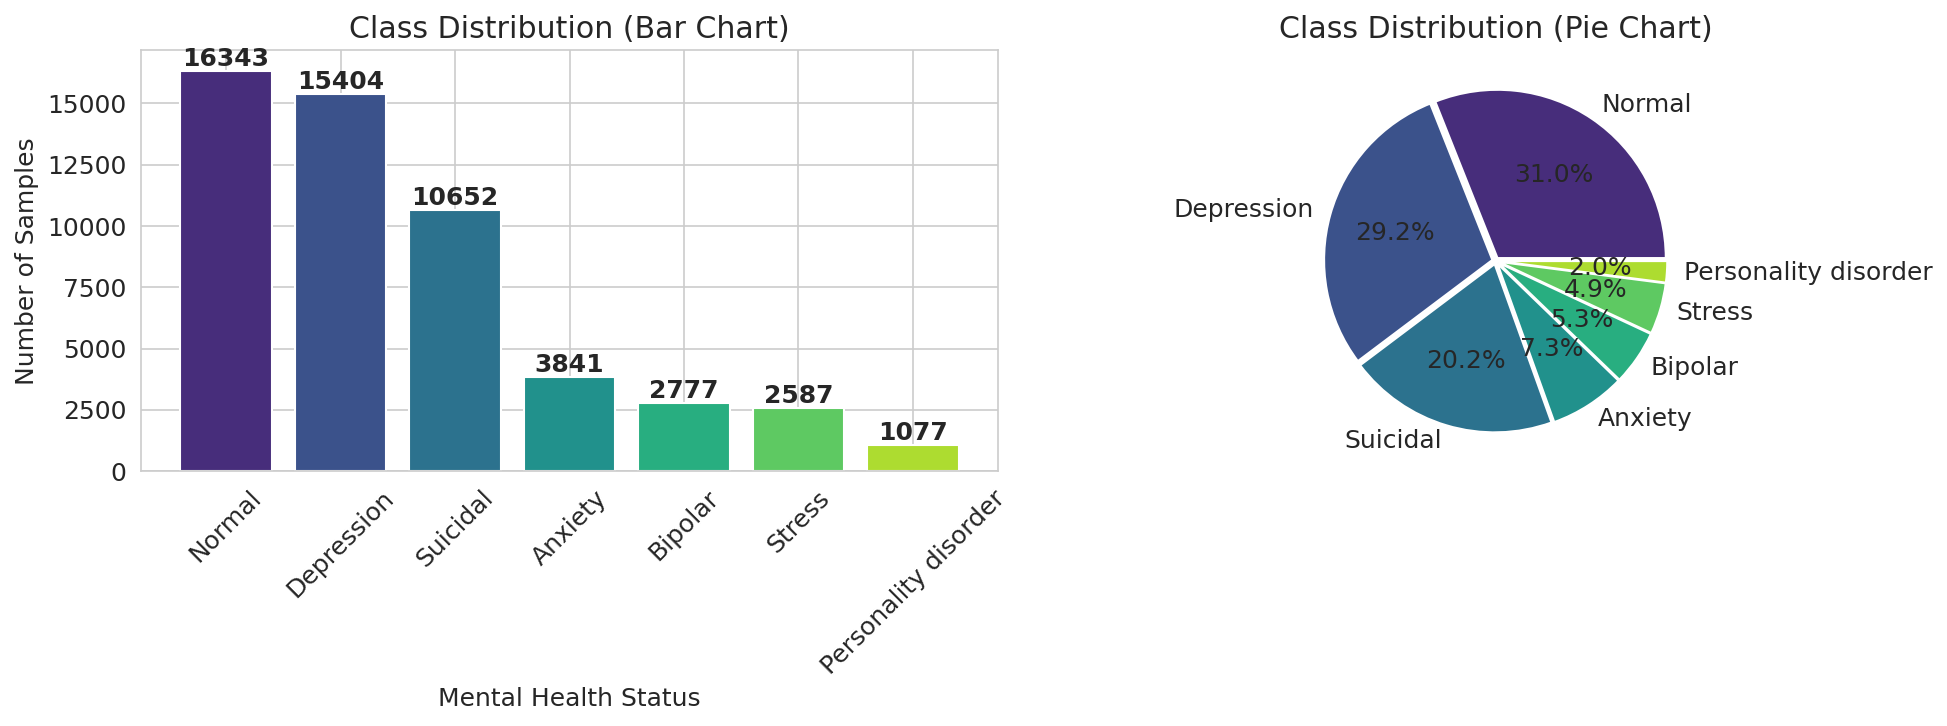


📊 Class Imbalance Ratio (max/min): 15.17


In [6]:
# --- EDA Visualization 1: Class Distribution ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts = df['status'].value_counts()
colors = sns.color_palette('viridis', len(class_counts))
axes[0].bar(class_counts.index, class_counts.values, color=colors)
axes[0].set_xlabel('Mental Health Status')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Class Distribution (Bar Chart)')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 200, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, explode=[0.02]*len(class_counts))
axes[1].set_title('Class Distribution (Pie Chart)')

plt.tight_layout()
plt.savefig('eda_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Class Imbalance Ratio (max/min): {class_counts.max()/class_counts.min():.2f}")

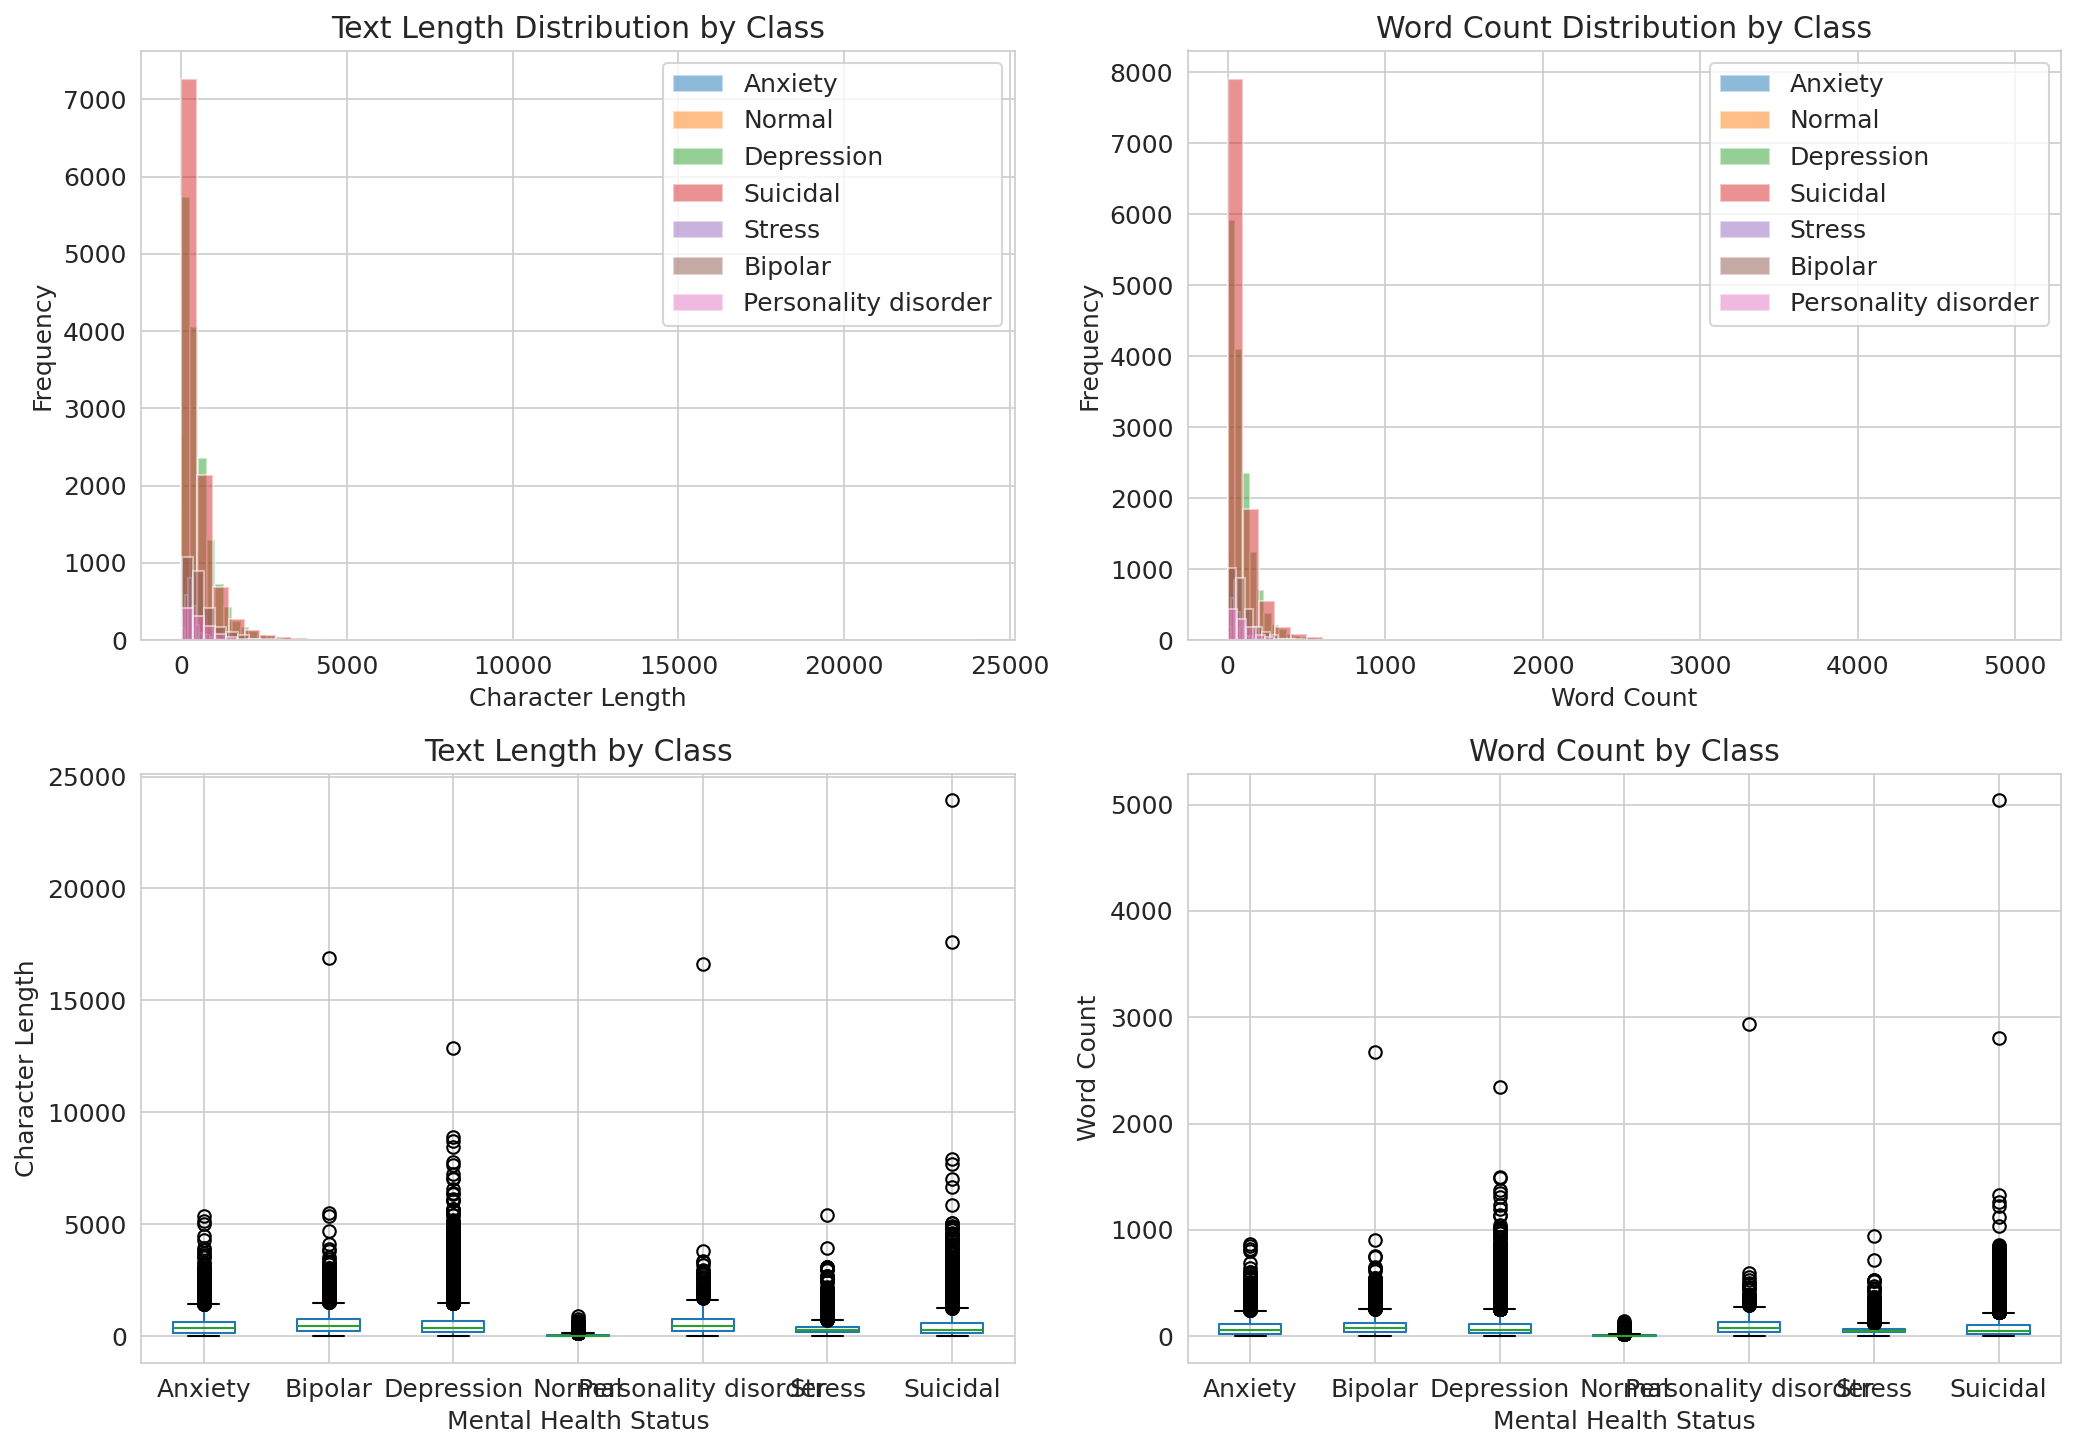


📊 Text Length Statistics:
                        count        mean         std  min   25%   50%    75%  \
status                                                                          
Anxiety                3841.0   84.579537   88.544883  1.0  25.0  60.0  112.0   
Bipolar                2777.0  102.341015  101.354114  2.0  43.0  75.0  129.0   
Depression            15404.0   93.514217  103.930552  0.0  31.0  63.0  120.0   
Normal                16343.0   10.209447   12.518859  0.0   3.0   6.0   11.0   
Personality disorder   1077.0  102.538533  122.759094  2.0  37.0  79.0  135.0   
Stress                 2587.0   65.272130   60.164458  1.0  36.0  49.0   72.0   
Suicidal              10652.0   81.517368  108.741694  0.0  23.0  51.0  103.0   

                         max  
status                        
Anxiety                868.0  
Bipolar               2674.0  
Depression            2346.0  
Normal                 147.0  
Personality disorder  2938.0  
Stress                 946

In [7]:
# --- EDA Visualization 2: Text Length Distribution ---
df['text_length'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Character length distribution
for status in df['status'].unique():
    subset = df[df['status'] == status]['text_length']
    axes[0, 0].hist(subset, bins=50, alpha=0.5, label=status)
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Text Length Distribution by Class')
axes[0, 0].legend()

# Word count distribution
for status in df['status'].unique():
    subset = df[df['status'] == status]['word_count']
    axes[0, 1].hist(subset, bins=50, alpha=0.5, label=status)
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Word Count Distribution by Class')
axes[0, 1].legend()

# Box plot for text length
df.boxplot(column='text_length', by='status', ax=axes[1, 0])
axes[1, 0].set_xlabel('Mental Health Status')
axes[1, 0].set_ylabel('Character Length')
axes[1, 0].set_title('Text Length by Class')
plt.suptitle('')

# Box plot for word count
df.boxplot(column='word_count', by='status', ax=axes[1, 1])
axes[1, 1].set_xlabel('Mental Health Status')
axes[1, 1].set_ylabel('Word Count')
axes[1, 1].set_title('Word Count by Class')
plt.suptitle('')

plt.tight_layout()
plt.savefig('eda_text_length.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
print("\n📊 Text Length Statistics:")
print(df.groupby('status')['word_count'].describe())

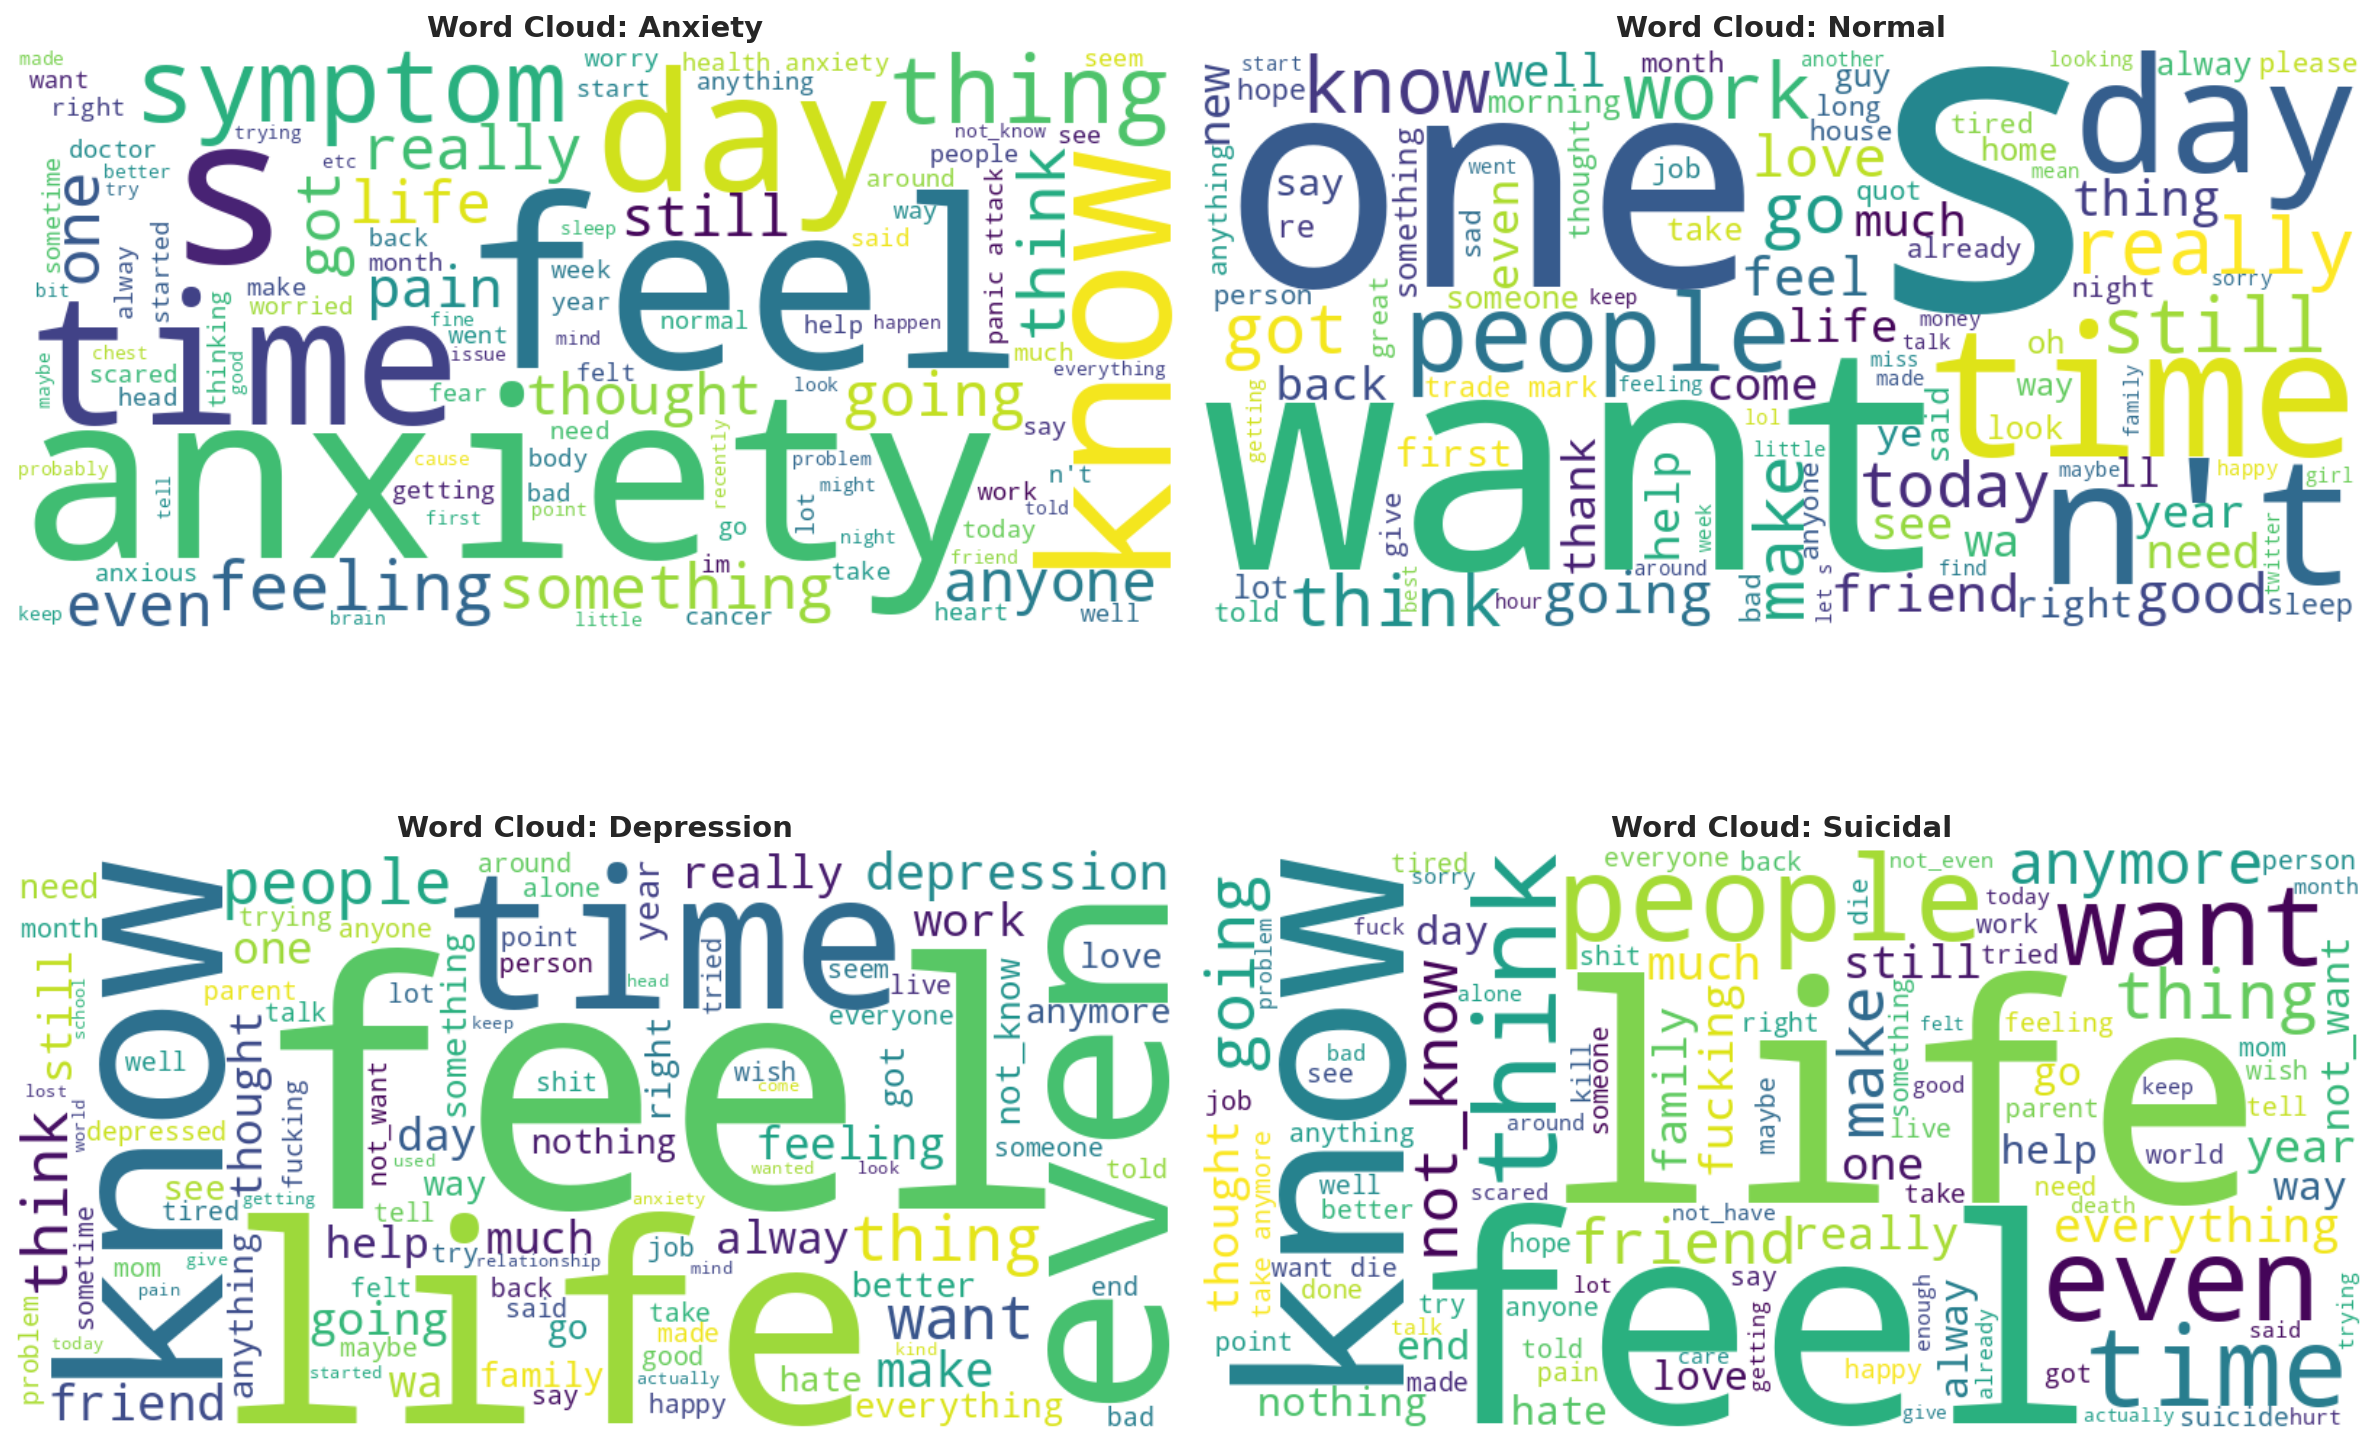

In [8]:
# --- EDA Visualization 3: Word Clouds by Class ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, status in enumerate(df['status'].unique()[:4]):  # Top 4 classes
    text = ' '.join(df[df['status'] == status]['clean_text'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='viridis', max_words=100).generate(text)
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud: {status}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('eda_wordclouds.png', dpi=150, bbox_inches='tight')
plt.show()

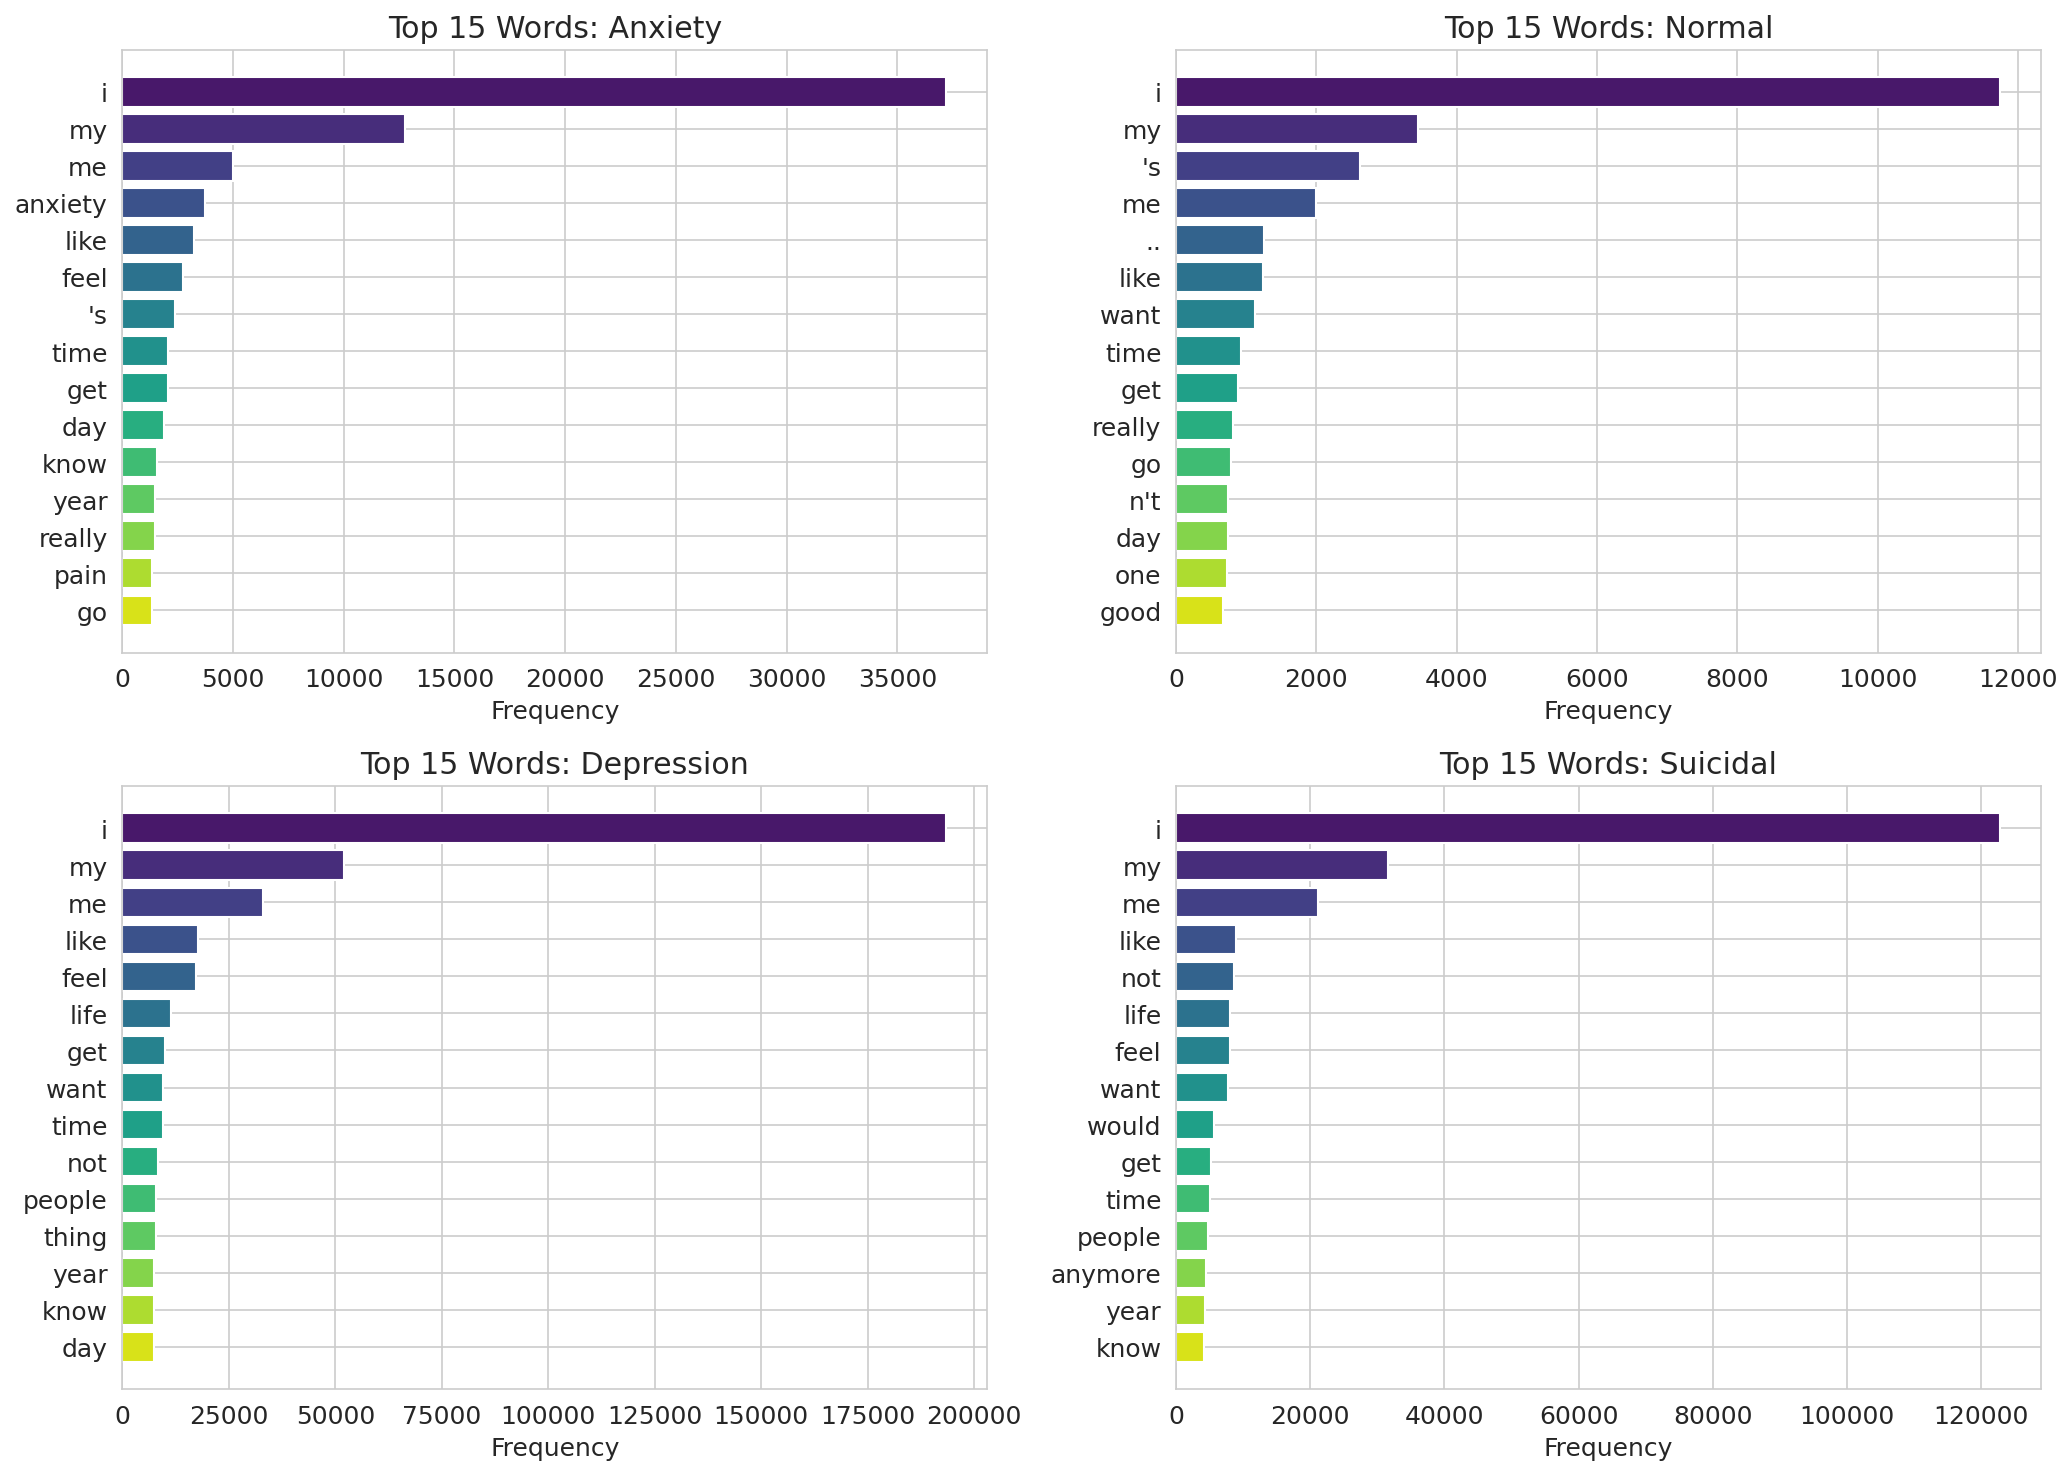

In [9]:
# --- EDA Visualization 4: Top Words per Class ---
def get_top_words(texts, n=15):
    """Get top n most frequent words from texts."""
    all_words = ' '.join(texts).split()
    return Counter(all_words).most_common(n)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, status in enumerate(df['status'].unique()[:4]):
    top_words = get_top_words(df[df['status'] == status]['clean_text'], n=15)
    words, counts = zip(*top_words)

    axes[idx].barh(range(len(words)), counts, color=sns.color_palette('viridis', 15))
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Frequency')
    axes[idx].set_title(f'Top 15 Words: {status}')

plt.tight_layout()
plt.savefig('eda_top_words.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Data Preparation for GRU Models

In [10]:
# --- Prepare Labels ---
label_map = {cat: i for i, cat in enumerate(df['status'].unique())}
reverse_label_map = {i: cat for cat, i in label_map.items()}

print("📋 Label Mapping:")
for label, idx in label_map.items():
    print(f"  {label} -> {idx}")

y = df['status'].map(label_map).values
num_classes = len(label_map)

# --- Train/Test Split ---
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['clean_text'], y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"\n📊 Data Split:")
print(f"  Training samples: {len(X_train_raw)}")
print(f"  Test samples: {len(X_test_raw)}")

# --- Calculate Class Weights for Imbalanced Data ---
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\n⚖️ Class Weights: {class_weight_dict}")

📋 Label Mapping:
  Anxiety -> 0
  Normal -> 1
  Depression -> 2
  Suicidal -> 3
  Stress -> 4
  Bipolar -> 5
  Personality disorder -> 6

📊 Data Split:
  Training samples: 42144
  Test samples: 10537

⚖️ Class Weights: {0: np.float64(1.9591836734693877), 1: np.float64(0.4604995738543237), 2: np.float64(0.4885637773733205), 3: np.float64(0.7065569098194376), 4: np.float64(2.908488612836439), 5: np.float64(2.710748054287001), 6: np.float64(6.984421610871727)}


## 5. GRU Model Implementations

### 5.1 GRU with TF-IDF Embeddings

TF-IDF (Term Frequency-Inverse Document Frequency) captures the importance of words in documents relative to the corpus.

In [11]:
# =====================================================
# GRU MODEL 1: TF-IDF EMBEDDINGS
# =====================================================

print("="*60)
print("GRU MODEL WITH TF-IDF EMBEDDINGS")
print("="*60)

# --- Hyperparameters ---
TFIDF_CONFIG = {
    "max_features": 5000,
    "ngram_range": (1, 2),
    "gru_units": 128,
    "dropout_rate": 0.5,
    "recurrent_dropout": 0.2,
    "dense_units": 64,
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 30
}

print("\n📋 GRU + TF-IDF Configuration:")
for key, value in TFIDF_CONFIG.items():
    print(f"  {key}: {value}")

GRU MODEL WITH TF-IDF EMBEDDINGS

📋 GRU + TF-IDF Configuration:
  max_features: 5000
  ngram_range: (1, 2)
  gru_units: 128
  dropout_rate: 0.5
  recurrent_dropout: 0.2
  dense_units: 64
  learning_rate: 0.001
  batch_size: 64
  epochs: 30


In [12]:
# --- TF-IDF Vectorization ---
tfidf_vectorizer = TfidfVectorizer(
    max_features=TFIDF_CONFIG['max_features'],
    ngram_range=TFIDF_CONFIG['ngram_range']
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw).toarray()

# Reshape for GRU: (samples, timesteps, features)
# Using timesteps=1 for TF-IDF (treating entire document as one timestep)
X_train_tfidf_gru = X_train_tfidf.reshape(-1, 1, TFIDF_CONFIG['max_features'])
X_test_tfidf_gru = X_test_tfidf.reshape(-1, 1, TFIDF_CONFIG['max_features'])

print(f"\n📊 TF-IDF Feature Shape:")
print(f"  Training: {X_train_tfidf_gru.shape}")
print(f"  Test: {X_test_tfidf_gru.shape}")


📊 TF-IDF Feature Shape:
  Training: (42144, 1, 5000)
  Test: (10537, 1, 5000)


In [13]:
# --- Build GRU Model with TF-IDF ---
def build_gru_tfidf(input_shape, num_classes, config):
    """Build Bidirectional GRU model for TF-IDF features."""
    model = Sequential([
        Bidirectional(
            GRU(config['gru_units'],
                dropout=config['dropout_rate'],
                recurrent_dropout=config['recurrent_dropout']),
            input_shape=input_shape
        ),
        BatchNormalization(),
        Dense(config['dense_units'], activation='relu'),
        Dropout(config['dropout_rate']),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build model
gru_tfidf_model = build_gru_tfidf(
    input_shape=(1, TFIDF_CONFIG['max_features']),
    num_classes=num_classes,
    config=TFIDF_CONFIG
)

print("\n🏗️ GRU + TF-IDF Model Architecture:")
gru_tfidf_model.summary()


🏗️ GRU + TF-IDF Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 256)            │     3,939,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,957,767 (15.10 MB)

 Trainable params: 3,957,255 (15.10 MB)

 Non-trainable params: 512 (2.00 KB)

In [14]:
# --- Callbacks ---
callbacks_tfidf = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# --- Train Model ---
print("\n🚀 Training GRU + TF-IDF Model...")
history_tfidf = gru_tfidf_model.fit(
    X_train_tfidf_gru, y_train,
    validation_split=0.1,
    epochs=TFIDF_CONFIG['epochs'],
    batch_size=TFIDF_CONFIG['batch_size'],
    callbacks=callbacks_tfidf,
    class_weight=class_weight_dict,
    verbose=1
)


🚀 Training GRU + TF-IDF Model...
Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.4450 - loss: 1.5167 - val_accuracy: 0.6112 - val_loss: 1.1808 - learning_rate: 0.0010
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6367 - loss: 0.9431 - val_accuracy: 0.6887 - val_loss: 0.8536 - learning_rate: 0.0010
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6793 - loss: 0.7875 - val_accuracy: 0.6963 - val_loss: 0.8184 - learning_rate: 0.0010
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7074 - loss: 0.6801 - val_accuracy: 0.7127 - val_loss: 0.7877 - learning_rate: 0.0010
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7227 - loss: 0.6060 - val_accuracy: 0.7134 - val_loss: 0.8020 - learning_rate: 0.0010
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7342 - loss: 0.5744 - val_accuracy: 0.7193 - val_loss: 0.8010 - learning_rate: 0.0010
Epoch 7/30
591/593 ━━━━━━━━━━━━━━━━━━━━ 0s

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

📊 GRU + TF-IDF - EVALUATION RESULTS
  Accuracy:  0.7107
  Precision: 0.6228
  Recall:    0.7193
  F1-Score:  0.6502

📋 Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.66      0.80      0.72       768
              Normal       0.90      0.90      0.90      3269
          Depression       0.76      0.49      0.59      3081
            Suicidal       0.61      0.71      0.66      2131
              Stress       0.43      0.59      0.50       517
             Bipolar       0.69      0.80      0.74       556
Personality disorder       0.31      0.75      0.44       215

            accuracy                           0.71     10537
           macro avg       0.62      0.72      0.65     10537
        weighted avg       0.74      0.71      0.71     10537



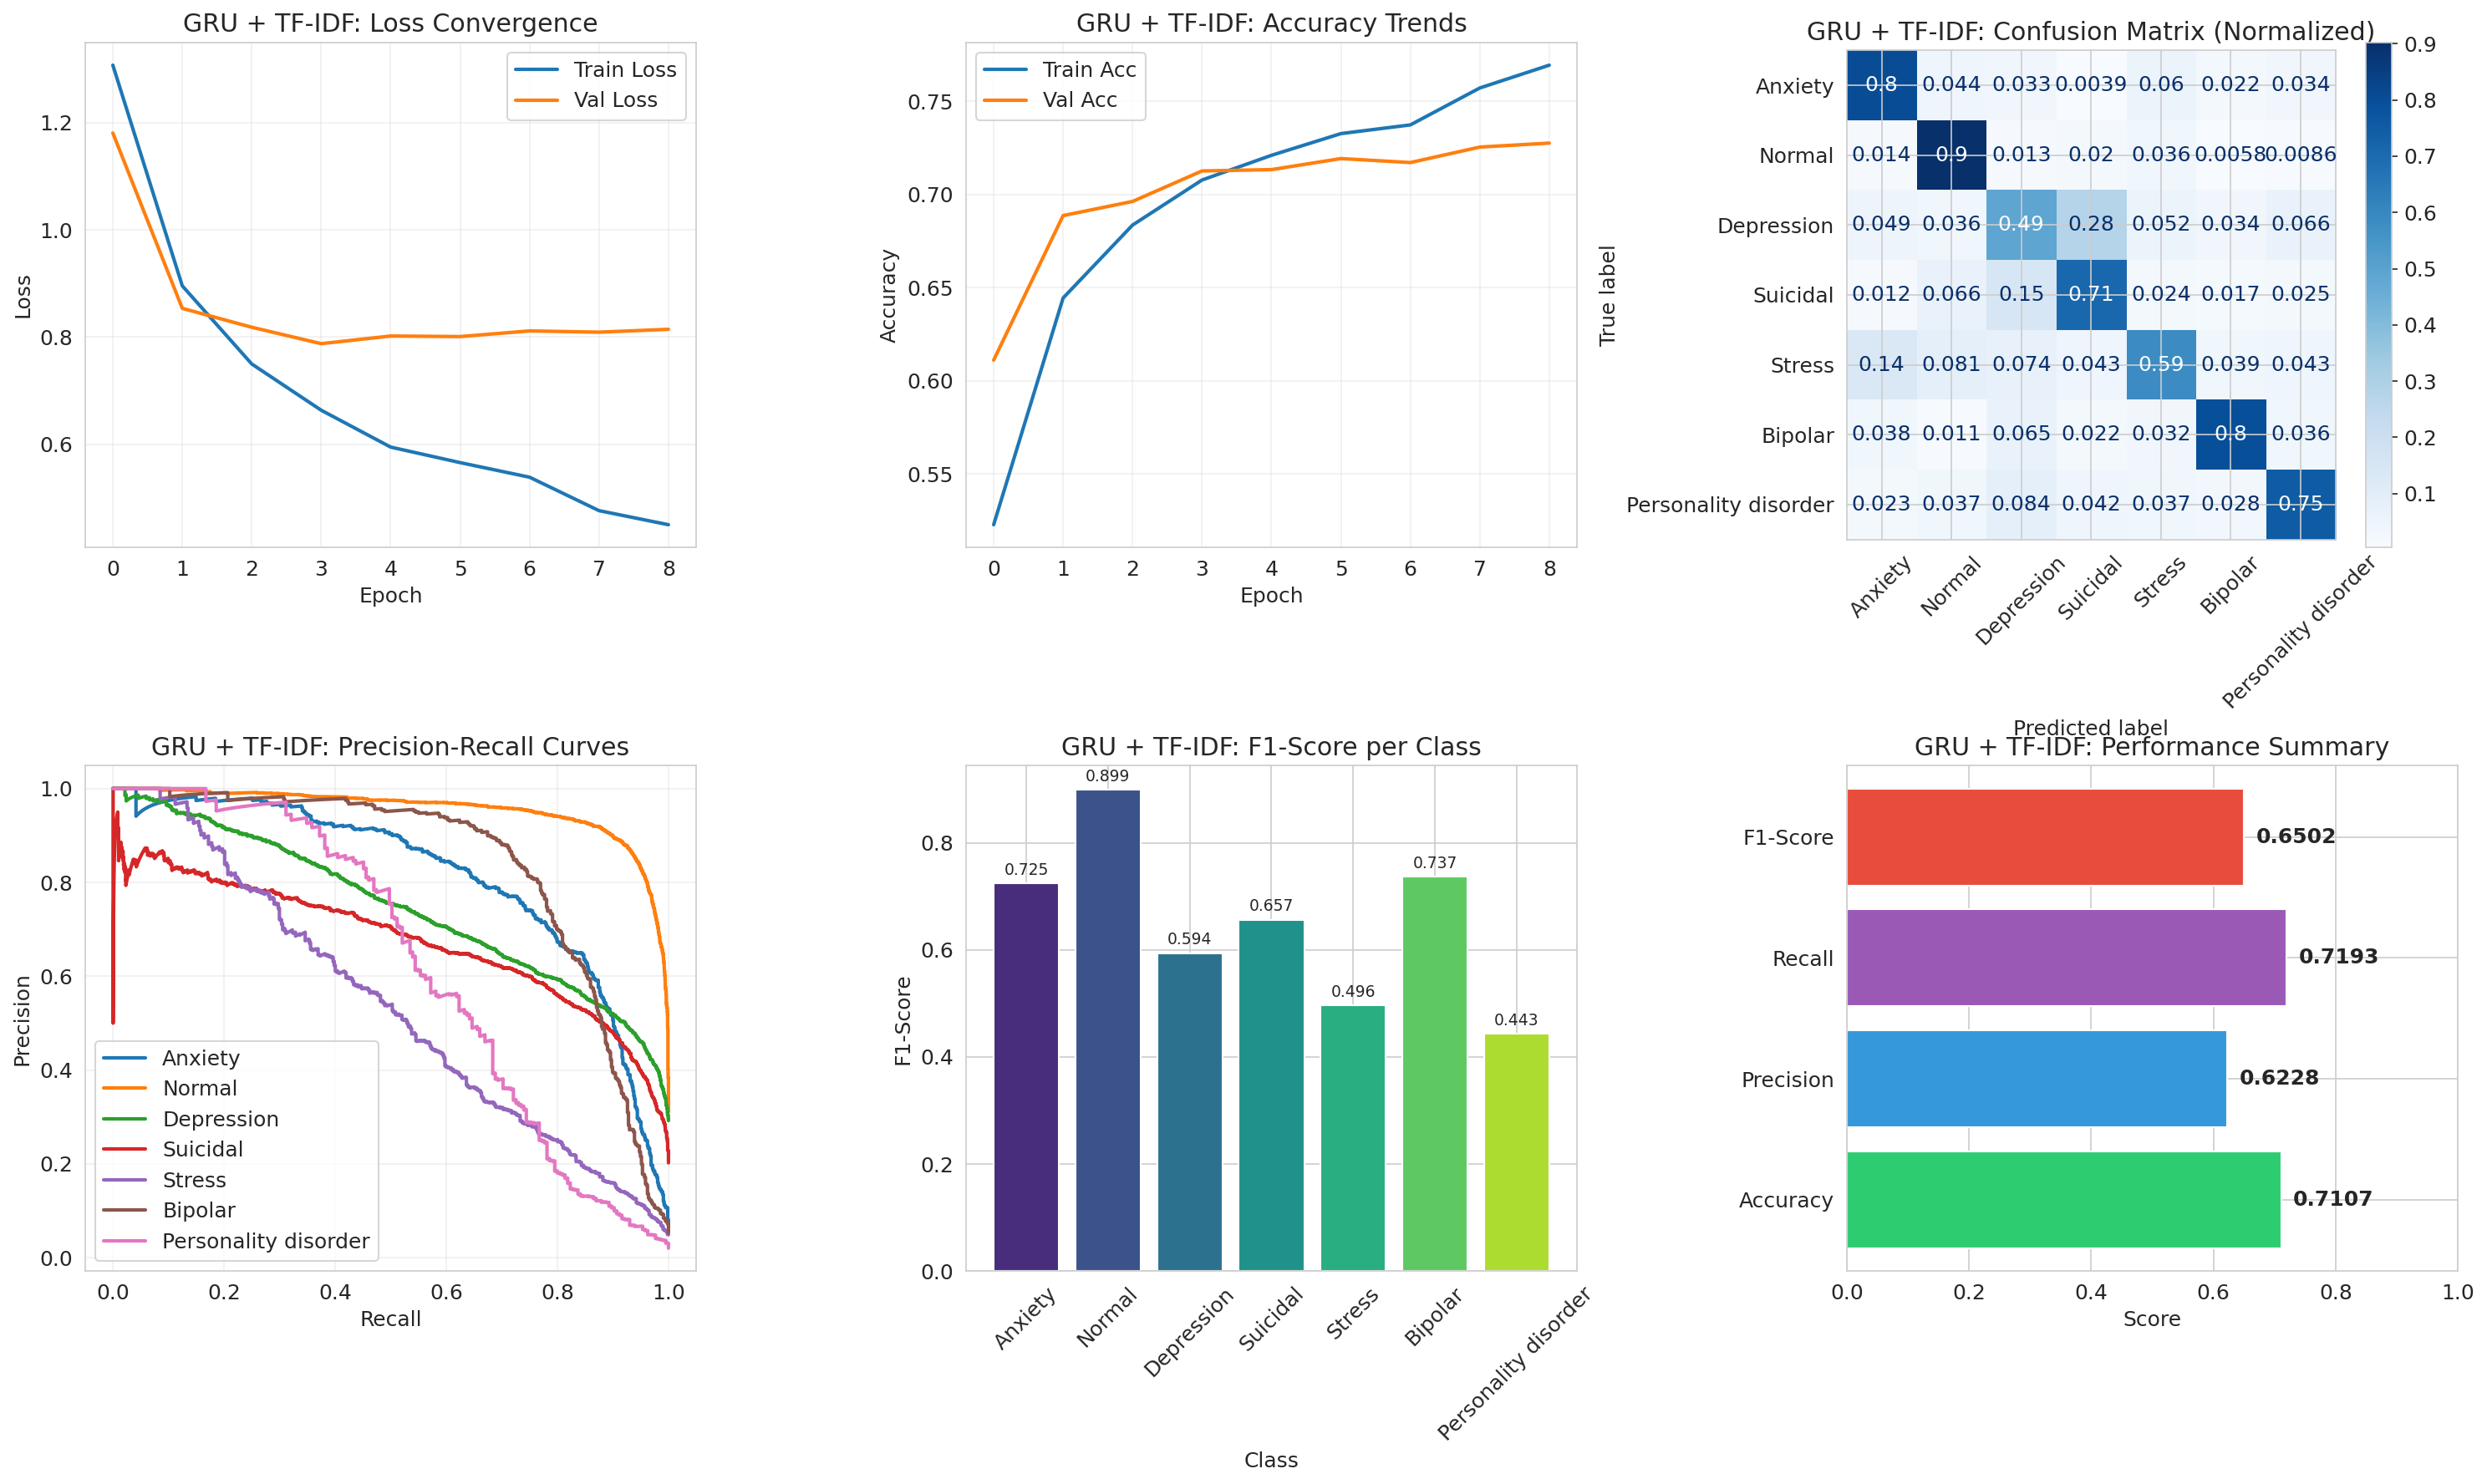

In [15]:
# --- Evaluate GRU + TF-IDF ---
def evaluate_model(model, X_test, y_test, label_map, model_name, history):
    """Comprehensive model evaluation with visualizations."""

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

    print(f"\n{'='*60}")
    print(f"📊 {model_name} - EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    # Classification Report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=list(label_map.keys())))

    # Visualizations
    fig = plt.figure(figsize=(20, 12))

    # 1. Training/Validation Loss
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name}: Loss Convergence')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Training/Validation Accuracy
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.plot(history.history['accuracy'], label='Train Acc', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{model_name}: Accuracy Trends')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Confusion Matrix
    ax3 = fig.add_subplot(2, 3, 3)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
    disp.plot(cmap='Blues', ax=ax3, xticks_rotation=45)
    ax3.set_title(f'{model_name}: Confusion Matrix (Normalized)')

    # 4. Precision-Recall Curves
    ax4 = fig.add_subplot(2, 3, 4)
    for i, class_name in enumerate(label_map.keys()):
        p, r, _ = precision_recall_curve((y_test == i).astype(int), y_pred_probs[:, i])
        ax4.plot(r, p, label=class_name, linewidth=2)
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title(f'{model_name}: Precision-Recall Curves')
    ax4.legend(loc='lower left')
    ax4.grid(True, alpha=0.3)

    # 5. F1-Score per Class
    ax5 = fig.add_subplot(2, 3, 5)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    classes = list(label_map.keys())
    f1_scores = [report_dict[str(label_map[c])]['f1-score'] for c in classes]
    bars = ax5.bar(classes, f1_scores, color=sns.color_palette('viridis', len(classes)))
    ax5.set_xlabel('Class')
    ax5.set_ylabel('F1-Score')
    ax5.set_title(f'{model_name}: F1-Score per Class')
    ax5.tick_params(axis='x', rotation=45)
    for bar, score in zip(bars, f1_scores):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontsize=9)

    # 6. Metrics Summary Bar
    ax6 = fig.add_subplot(2, 3, 6)
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [accuracy, precision, recall, f1]
    bars = ax6.barh(metrics_names, metrics_values, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
    ax6.set_xlim(0, 1)
    ax6.set_xlabel('Score')
    ax6.set_title(f'{model_name}: Performance Summary')
    for bar, value in zip(bars, metrics_values):
        ax6.text(value + 0.02, bar.get_y() + bar.get_height()/2,
                f'{value:.4f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_").lower()}_evaluation.png', dpi=150, bbox_inches='tight')
    plt.show()

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }

# Evaluate GRU + TF-IDF
results_tfidf = evaluate_model(
    gru_tfidf_model, X_test_tfidf_gru, y_test,
    label_map, "GRU + TF-IDF", history_tfidf
)

### 5.2 GRU with Word2Vec (Skip-gram) Embeddings

Word2Vec Skip-gram learns word representations by predicting context words from a target word.

In [16]:
# =====================================================
# GRU MODEL 2: WORD2VEC (SKIP-GRAM) EMBEDDINGS
# =====================================================

print("="*60)
print("GRU MODEL WITH WORD2VEC (SKIP-GRAM) EMBEDDINGS")
print("="*60)

# --- Hyperparameters ---
W2V_CONFIG = {
    "embedding_dim": 100,
    "max_sequence_length": 100,
    "max_vocab_size": 10000,
    "w2v_window": 5,
    "w2v_min_count": 2,
    "w2v_epochs": 20,
    "gru_units": 128,
    "dropout_rate": 0.5,
    "recurrent_dropout": 0.2,
    "dense_units": 64,
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 30
}

print("\n📋 GRU + Word2Vec (Skip-gram) Configuration:")
for key, value in W2V_CONFIG.items():
    print(f"  {key}: {value}")

GRU MODEL WITH WORD2VEC (SKIP-GRAM) EMBEDDINGS

📋 GRU + Word2Vec (Skip-gram) Configuration:
  embedding_dim: 100
  max_sequence_length: 100
  max_vocab_size: 10000
  w2v_window: 5
  w2v_min_count: 2
  w2v_epochs: 20
  gru_units: 128
  dropout_rate: 0.5
  recurrent_dropout: 0.2
  dense_units: 64
  learning_rate: 0.001
  batch_size: 64
  epochs: 30


In [17]:
# --- Tokenize texts for Word2Vec ---
tokenized_texts = [text.split() for text in df['clean_text'].tolist()]

# --- Train Word2Vec Skip-gram Model ---
print("\n⏳ Training Word2Vec (Skip-gram) model...")
w2v_skipgram = Word2Vec(
    sentences=tokenized_texts,
    vector_size=W2V_CONFIG['embedding_dim'],
    window=W2V_CONFIG['w2v_window'],
    min_count=W2V_CONFIG['w2v_min_count'],
    sg=1,  # Skip-gram
    workers=4,
    epochs=W2V_CONFIG['w2v_epochs'],
    seed=SEED
)

print(f"✅ Word2Vec vocabulary size: {len(w2v_skipgram.wv)}")


⏳ Training Word2Vec (Skip-gram) model...
✅ Word2Vec vocabulary size: 32387


In [18]:
# --- Prepare sequences for GRU ---
# Tokenizer for converting text to sequences
tokenizer = Tokenizer(num_words=W2V_CONFIG['max_vocab_size'], oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_raw)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Pad sequences
X_train_w2v = pad_sequences(X_train_seq, maxlen=W2V_CONFIG['max_sequence_length'], padding='post')
X_test_w2v = pad_sequences(X_test_seq, maxlen=W2V_CONFIG['max_sequence_length'], padding='post')

print(f"\n📊 Sequence Shape:")
print(f"  Training: {X_train_w2v.shape}")
print(f"  Test: {X_test_w2v.shape}")
print(f"  Vocabulary size: {len(tokenizer.word_index)}")


📊 Sequence Shape:
  Training: (42144, 100)
  Test: (10537, 100)
  Vocabulary size: 48909


In [19]:
# --- Create Embedding Matrix from Word2Vec ---
vocab_size = min(len(tokenizer.word_index) + 1, W2V_CONFIG['max_vocab_size'])
embedding_matrix_w2v = np.zeros((vocab_size, W2V_CONFIG['embedding_dim']))

words_found = 0
for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        continue
    if word in w2v_skipgram.wv:
        embedding_matrix_w2v[idx] = w2v_skipgram.wv[word]
        words_found += 1

print(f"\n📊 Word2Vec Embedding Matrix:")
print(f"  Shape: {embedding_matrix_w2v.shape}")
print(f"  Words found: {words_found}/{vocab_size} ({100*words_found/vocab_size:.1f}%)")


📊 Word2Vec Embedding Matrix:
  Shape: (10000, 100)
  Words found: 9768/10000 (97.7%)


In [20]:
# --- Build GRU Model with Word2Vec Embeddings ---
def build_gru_embedding(vocab_size, embedding_dim, embedding_matrix, max_length, num_classes, config, trainable=False):
    """Build Bidirectional GRU model with pre-trained embeddings."""
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_length,
            trainable=trainable  # Fine-tune embeddings or keep frozen
        ),
        SpatialDropout1D(0.2),
        Bidirectional(
            GRU(config['gru_units'],
                dropout=config['dropout_rate'],
                recurrent_dropout=config['recurrent_dropout'],
                return_sequences=False)
        ),
        BatchNormalization(),
        Dense(config['dense_units'], activation='relu'),
        Dropout(config['dropout_rate']),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build Word2Vec model
gru_w2v_model = build_gru_embedding(
    vocab_size=vocab_size,
    embedding_dim=W2V_CONFIG['embedding_dim'],
    embedding_matrix=embedding_matrix_w2v,
    max_length=W2V_CONFIG['max_sequence_length'],
    num_classes=num_classes,
    config=W2V_CONFIG,
    trainable=True  # Allow fine-tuning
)

print("\n🏗️ GRU + Word2Vec (Skip-gram) Model Architecture:")
gru_w2v_model.summary()


🏗️ GRU + Word2Vec (Skip-gram) Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# --- Train GRU + Word2Vec Model ---
callbacks_w2v = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

print("\n🚀 Training GRU + Word2Vec (Skip-gram) Model...")
history_w2v = gru_w2v_model.fit(
    X_train_w2v, y_train,
    validation_split=0.1,
    epochs=W2V_CONFIG['epochs'],
    batch_size=W2V_CONFIG['batch_size'],
    callbacks=callbacks_w2v,
    class_weight=class_weight_dict,
    verbose=1
)


🚀 Training GRU + Word2Vec (Skip-gram) Model...
Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 319s 525ms/step - accuracy: 0.3175 - loss: 2.0635 - val_accuracy: 0.5079 - val_loss: 1.1983 - learning_rate: 0.0010
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 315s 516ms/step - accuracy: 0.4972 - loss: 1.3863 - val_accuracy: 0.5791 - val_loss: 0.9479 - learning_rate: 0.0010
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 304s 513ms/step - accuracy: 0.5720 - loss: 1.0949 - val_accuracy: 0.6365 - val_loss: 0.8170 - learning_rate: 0.0010
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 304s 512ms/step - accuracy: 0.6206 - loss: 0.9587 - val_accuracy: 0.6560 - val_loss: 0.7732 - learning_rate: 0.0010
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 309s 521ms/step - accuracy: 0.6544 - loss: 0.8724 - val_accuracy: 0.6994 - val_loss: 0.7631 - learning_rate: 0.0010
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 308s 519ms/step - accuracy: 0.6759 - loss: 0.7952 - val_accuracy: 0.6873 - val_loss: 0.7660 - learning_rate: 0.0010
Epoch 7/30
593/5

330/330 ━━━━━━━━━━━━━━━━━━━━ 37s 110ms/step

📊 GRU + Word2Vec (Skip-gram) - EVALUATION RESULTS
  Accuracy:  0.7446
  Precision: 0.6996
  Recall:    0.7473
  F1-Score:  0.7119

📋 Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.77      0.82      0.79       768
              Normal       0.96      0.88      0.91      3269
          Depression       0.79      0.54      0.64      3081
            Suicidal       0.59      0.81      0.68      2131
              Stress       0.45      0.74      0.56       517
             Bipolar       0.76      0.79      0.78       556
Personality disorder       0.59      0.65      0.62       215

            accuracy                           0.74     10537
           macro avg       0.70      0.75      0.71     10537
        weighted avg       0.78      0.74      0.75     10537



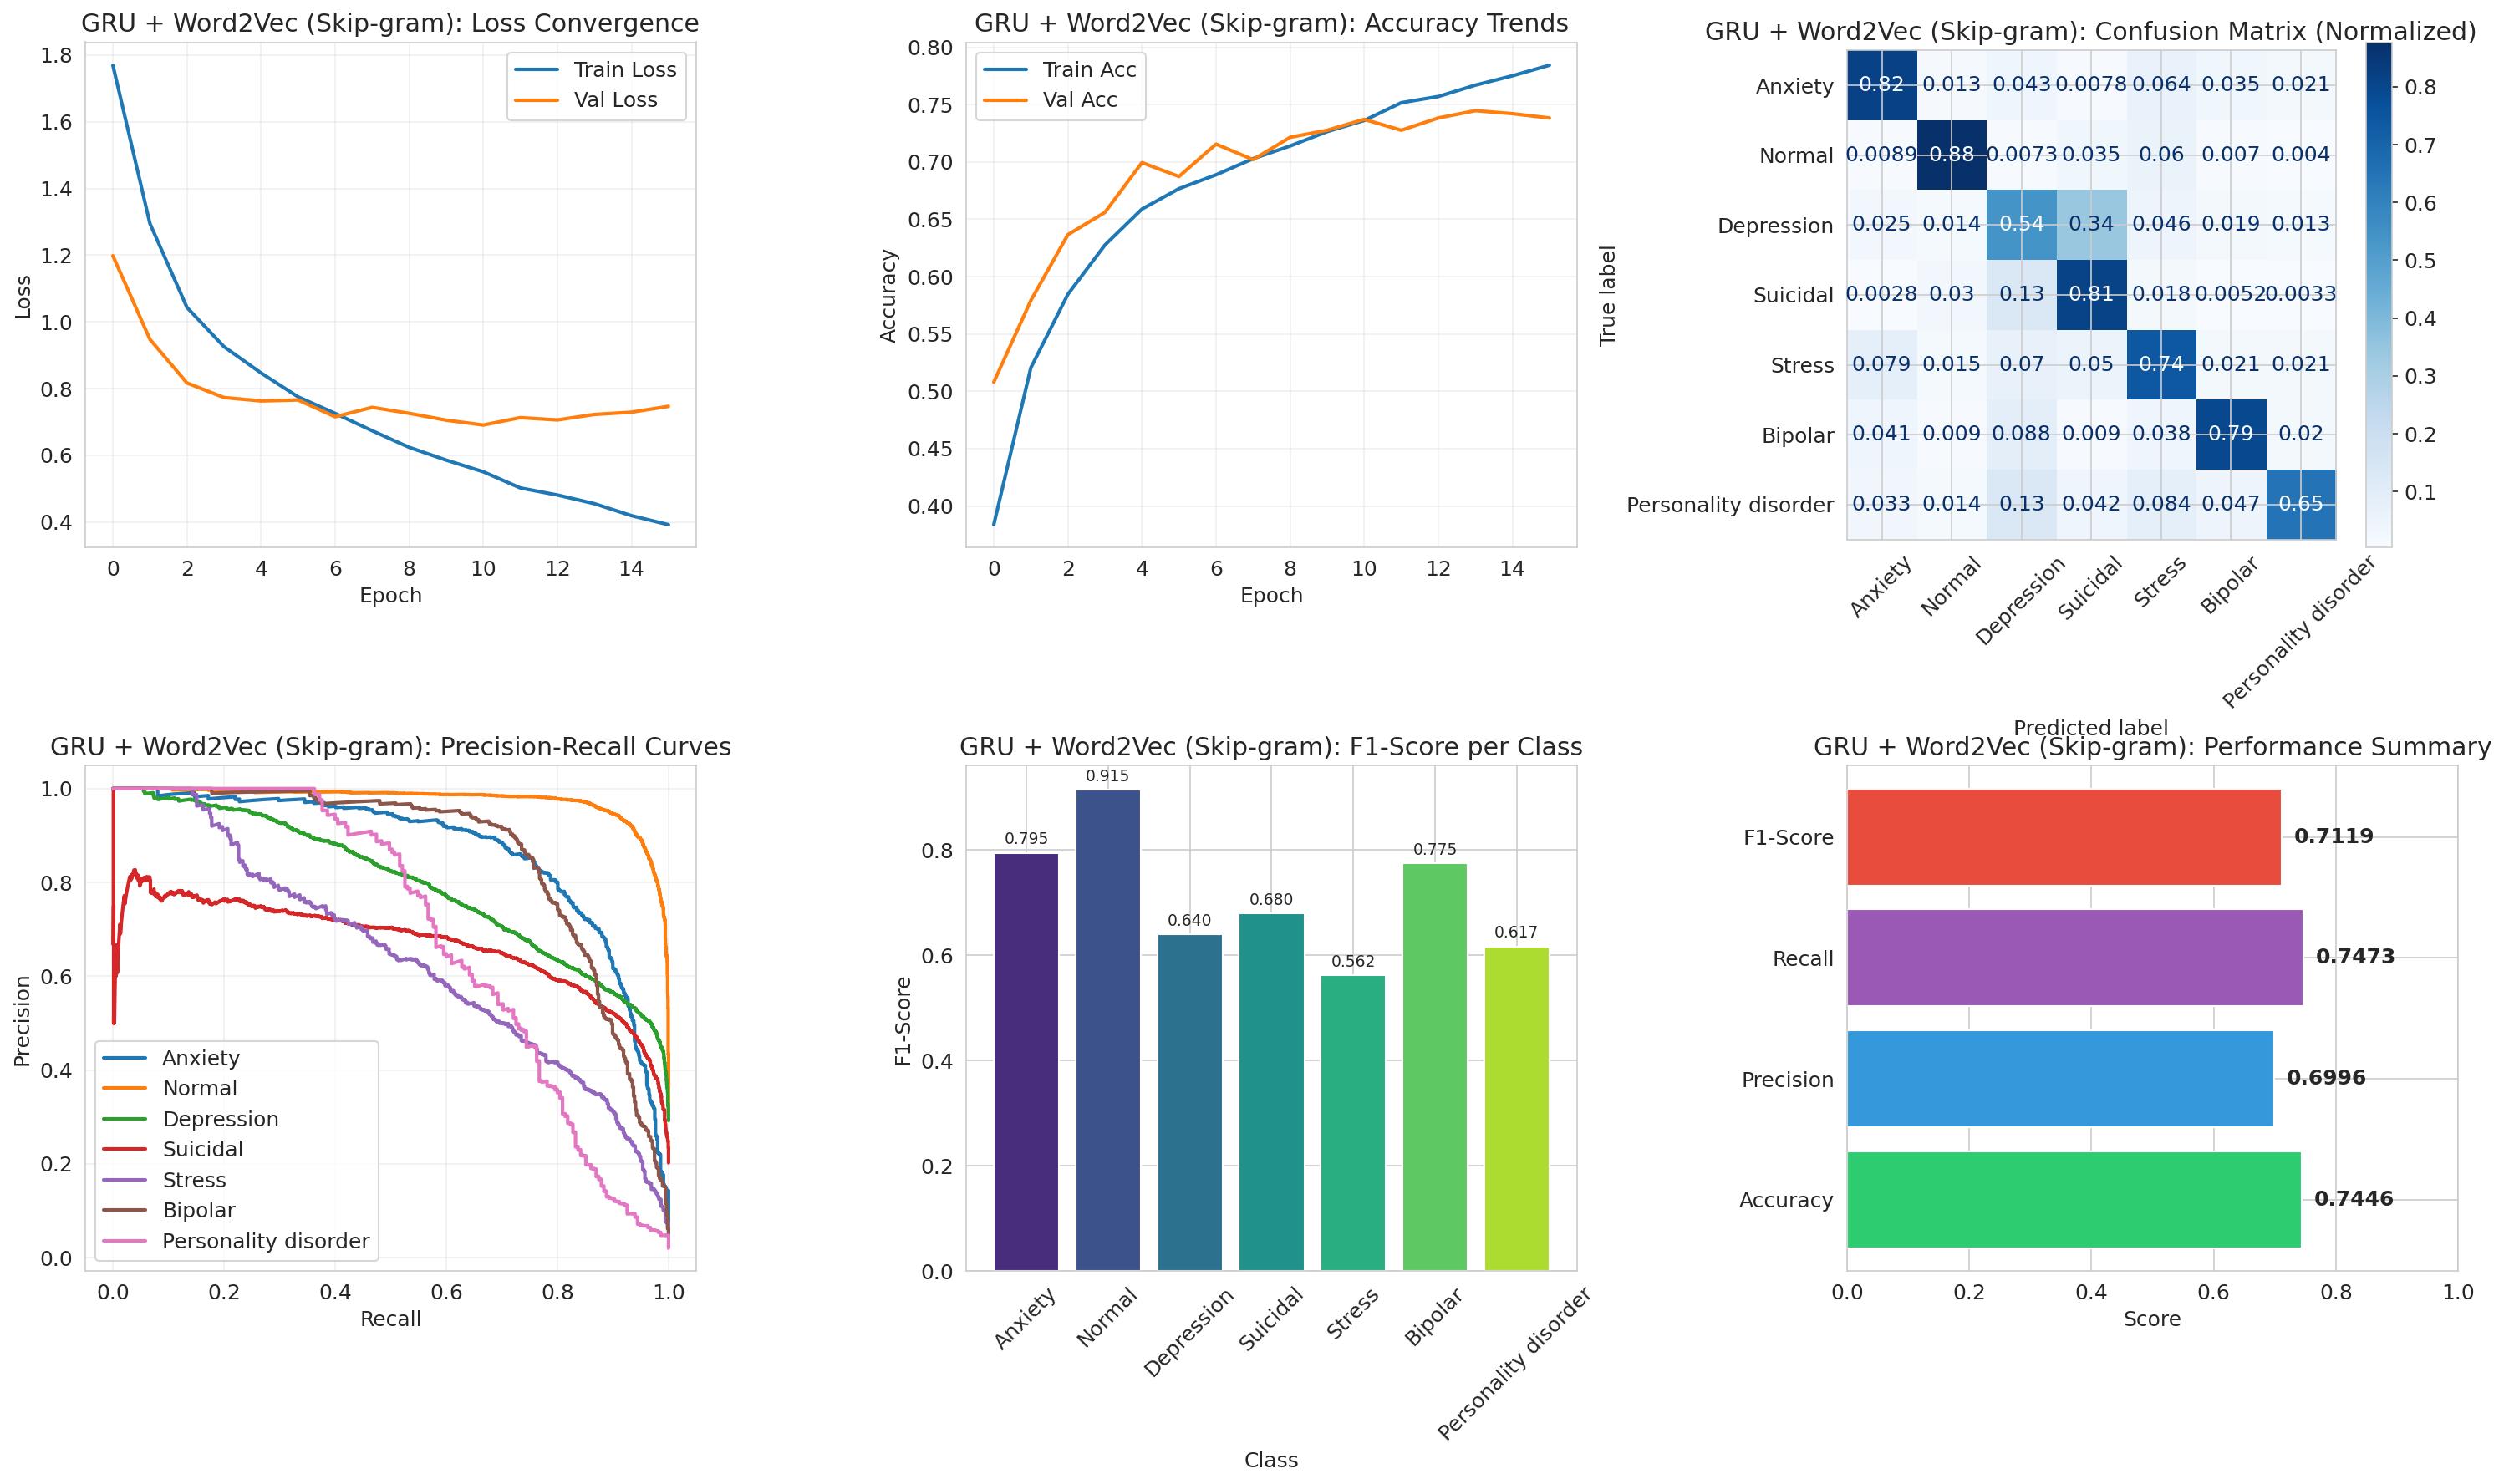

In [22]:
# --- Evaluate GRU + Word2Vec ---
results_w2v = evaluate_model(
    gru_w2v_model, X_test_w2v, y_test,
    label_map, "GRU + Word2Vec (Skip-gram)", history_w2v
)

### 5.3 GRU with GloVe Embeddings

GloVe (Global Vectors) learns word representations from global word-word co-occurrence statistics.

In [23]:
# =====================================================
# GRU MODEL 3: GLOVE EMBEDDINGS
# =====================================================

print("="*60)
print("GRU MODEL WITH GLOVE EMBEDDINGS")
print("="*60)

# --- Download GloVe embeddings ---
# Using 100-dimensional GloVe trained on Wikipedia + Gigaword
GLOVE_CONFIG = {
    "embedding_dim": 100,
    "max_sequence_length": 100,
    "max_vocab_size": 10000,
    "gru_units": 128,
    "dropout_rate": 0.5,
    "recurrent_dropout": 0.2,
    "dense_units": 64,
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 30
}

print("\n📋 GRU + GloVe Configuration:")
for key, value in GLOVE_CONFIG.items():
    print(f"  {key}: {value}")

GRU MODEL WITH GLOVE EMBEDDINGS

📋 GRU + GloVe Configuration:
  embedding_dim: 100
  max_sequence_length: 100
  max_vocab_size: 10000
  gru_units: 128
  dropout_rate: 0.5
  recurrent_dropout: 0.2
  dense_units: 64
  learning_rate: 0.001
  batch_size: 64
  epochs: 30


In [24]:
# --- Download and Load GloVe ---
import urllib.request

GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_DIR = "/content/glove"
GLOVE_FILE = f"{GLOVE_DIR}/glove.6B.100d.txt"

# Create directory
os.makedirs(GLOVE_DIR, exist_ok=True)

# Download if not exists
if not os.path.exists(GLOVE_FILE):
    print("⏳ Downloading GloVe embeddings (this may take a few minutes)...")
    zip_path = f"{GLOVE_DIR}/glove.6B.zip"
    urllib.request.urlretrieve(GLOVE_URL, zip_path)

    print("📦 Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(GLOVE_DIR)
    os.remove(zip_path)
    print("✅ GloVe downloaded and extracted!")
else:
    print("✅ GloVe embeddings already available.")

⏳ Downloading GloVe embeddings (this may take a few minutes)...
📦 Extracting...
✅ GloVe downloaded and extracted!


In [25]:
# --- Load GloVe Embeddings ---
print("\n⏳ Loading GloVe embeddings...")

glove_embeddings = {}
with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

print(f"✅ Loaded {len(glove_embeddings)} word vectors from GloVe.")


⏳ Loading GloVe embeddings...
✅ Loaded 400000 word vectors from GloVe.


In [26]:
# --- Create GloVe Embedding Matrix ---
vocab_size_glove = min(len(tokenizer.word_index) + 1, GLOVE_CONFIG['max_vocab_size'])
embedding_matrix_glove = np.zeros((vocab_size_glove, GLOVE_CONFIG['embedding_dim']))

words_found_glove = 0
for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size_glove:
        continue
    if word in glove_embeddings:
        embedding_matrix_glove[idx] = glove_embeddings[word]
        words_found_glove += 1

print(f"\n📊 GloVe Embedding Matrix:")
print(f"  Shape: {embedding_matrix_glove.shape}")
print(f"  Words found: {words_found_glove}/{vocab_size_glove} ({100*words_found_glove/vocab_size_glove:.1f}%)")


📊 GloVe Embedding Matrix:
  Shape: (10000, 100)
  Words found: 9729/10000 (97.3%)


In [27]:
# --- Prepare sequences for GloVe (same tokenizer as Word2Vec) ---
X_train_glove = pad_sequences(X_train_seq, maxlen=GLOVE_CONFIG['max_sequence_length'], padding='post')
X_test_glove = pad_sequences(X_test_seq, maxlen=GLOVE_CONFIG['max_sequence_length'], padding='post')

print(f"\n📊 GloVe Sequence Shape:")
print(f"  Training: {X_train_glove.shape}")
print(f"  Test: {X_test_glove.shape}")


📊 GloVe Sequence Shape:
  Training: (42144, 100)
  Test: (10537, 100)


In [28]:
# --- Build GRU Model with GloVe Embeddings ---
gru_glove_model = build_gru_embedding(
    vocab_size=vocab_size_glove,
    embedding_dim=GLOVE_CONFIG['embedding_dim'],
    embedding_matrix=embedding_matrix_glove,
    max_length=GLOVE_CONFIG['max_sequence_length'],
    num_classes=num_classes,
    config=GLOVE_CONFIG,
    trainable=True  # Allow fine-tuning
)

print("\n🏗️ GRU + GloVe Model Architecture:")
gru_glove_model.summary()


🏗️ GRU + GloVe Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# --- Train GRU + GloVe Model ---
callbacks_glove = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

print("\n🚀 Training GRU + GloVe Model...")
history_glove = gru_glove_model.fit(
    X_train_glove, y_train,
    validation_split=0.1,
    epochs=GLOVE_CONFIG['epochs'],
    batch_size=GLOVE_CONFIG['batch_size'],
    callbacks=callbacks_glove,
    class_weight=class_weight_dict,
    verbose=1
)


🚀 Training GRU + GloVe Model...
Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 324s 535ms/step - accuracy: 0.2860 - loss: 2.1189 - val_accuracy: 0.4168 - val_loss: 1.3078 - learning_rate: 0.0010
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 322s 535ms/step - accuracy: 0.4555 - loss: 1.5009 - val_accuracy: 0.5950 - val_loss: 1.0181 - learning_rate: 0.0010
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 321s 534ms/step - accuracy: 0.5536 - loss: 1.1981 - val_accuracy: 0.6391 - val_loss: 0.9026 - learning_rate: 0.0010
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 325s 539ms/step - accuracy: 0.6051 - loss: 1.0356 - val_accuracy: 0.6667 - val_loss: 0.8661 - learning_rate: 0.0010
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 321s 538ms/step - accuracy: 0.6358 - loss: 0.9549 - val_accuracy: 0.6828 - val_loss: 0.8032 - learning_rate: 0.0010
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 321s 537ms/step - accuracy: 0.6672 - loss: 0.8508 - val_accuracy: 0.6973 - val_loss: 0.7587 - learning_rate: 0.0010
Epoch 7/30
593/593 ━━━━━━━━━━━━

330/330 ━━━━━━━━━━━━━━━━━━━━ 36s 106ms/step

📊 GRU + GloVe - EVALUATION RESULTS
  Accuracy:  0.7441
  Precision: 0.6948
  Recall:    0.7485
  F1-Score:  0.7085

📋 Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.75      0.83      0.79       768
              Normal       0.94      0.90      0.92      3269
          Depression       0.81      0.50      0.62      3081
            Suicidal       0.58      0.82      0.68      2131
              Stress       0.47      0.70      0.56       517
             Bipolar       0.77      0.78      0.77       556
Personality disorder       0.54      0.70      0.61       215

            accuracy                           0.74     10537
           macro avg       0.69      0.75      0.71     10537
        weighted avg       0.78      0.74      0.74     10537



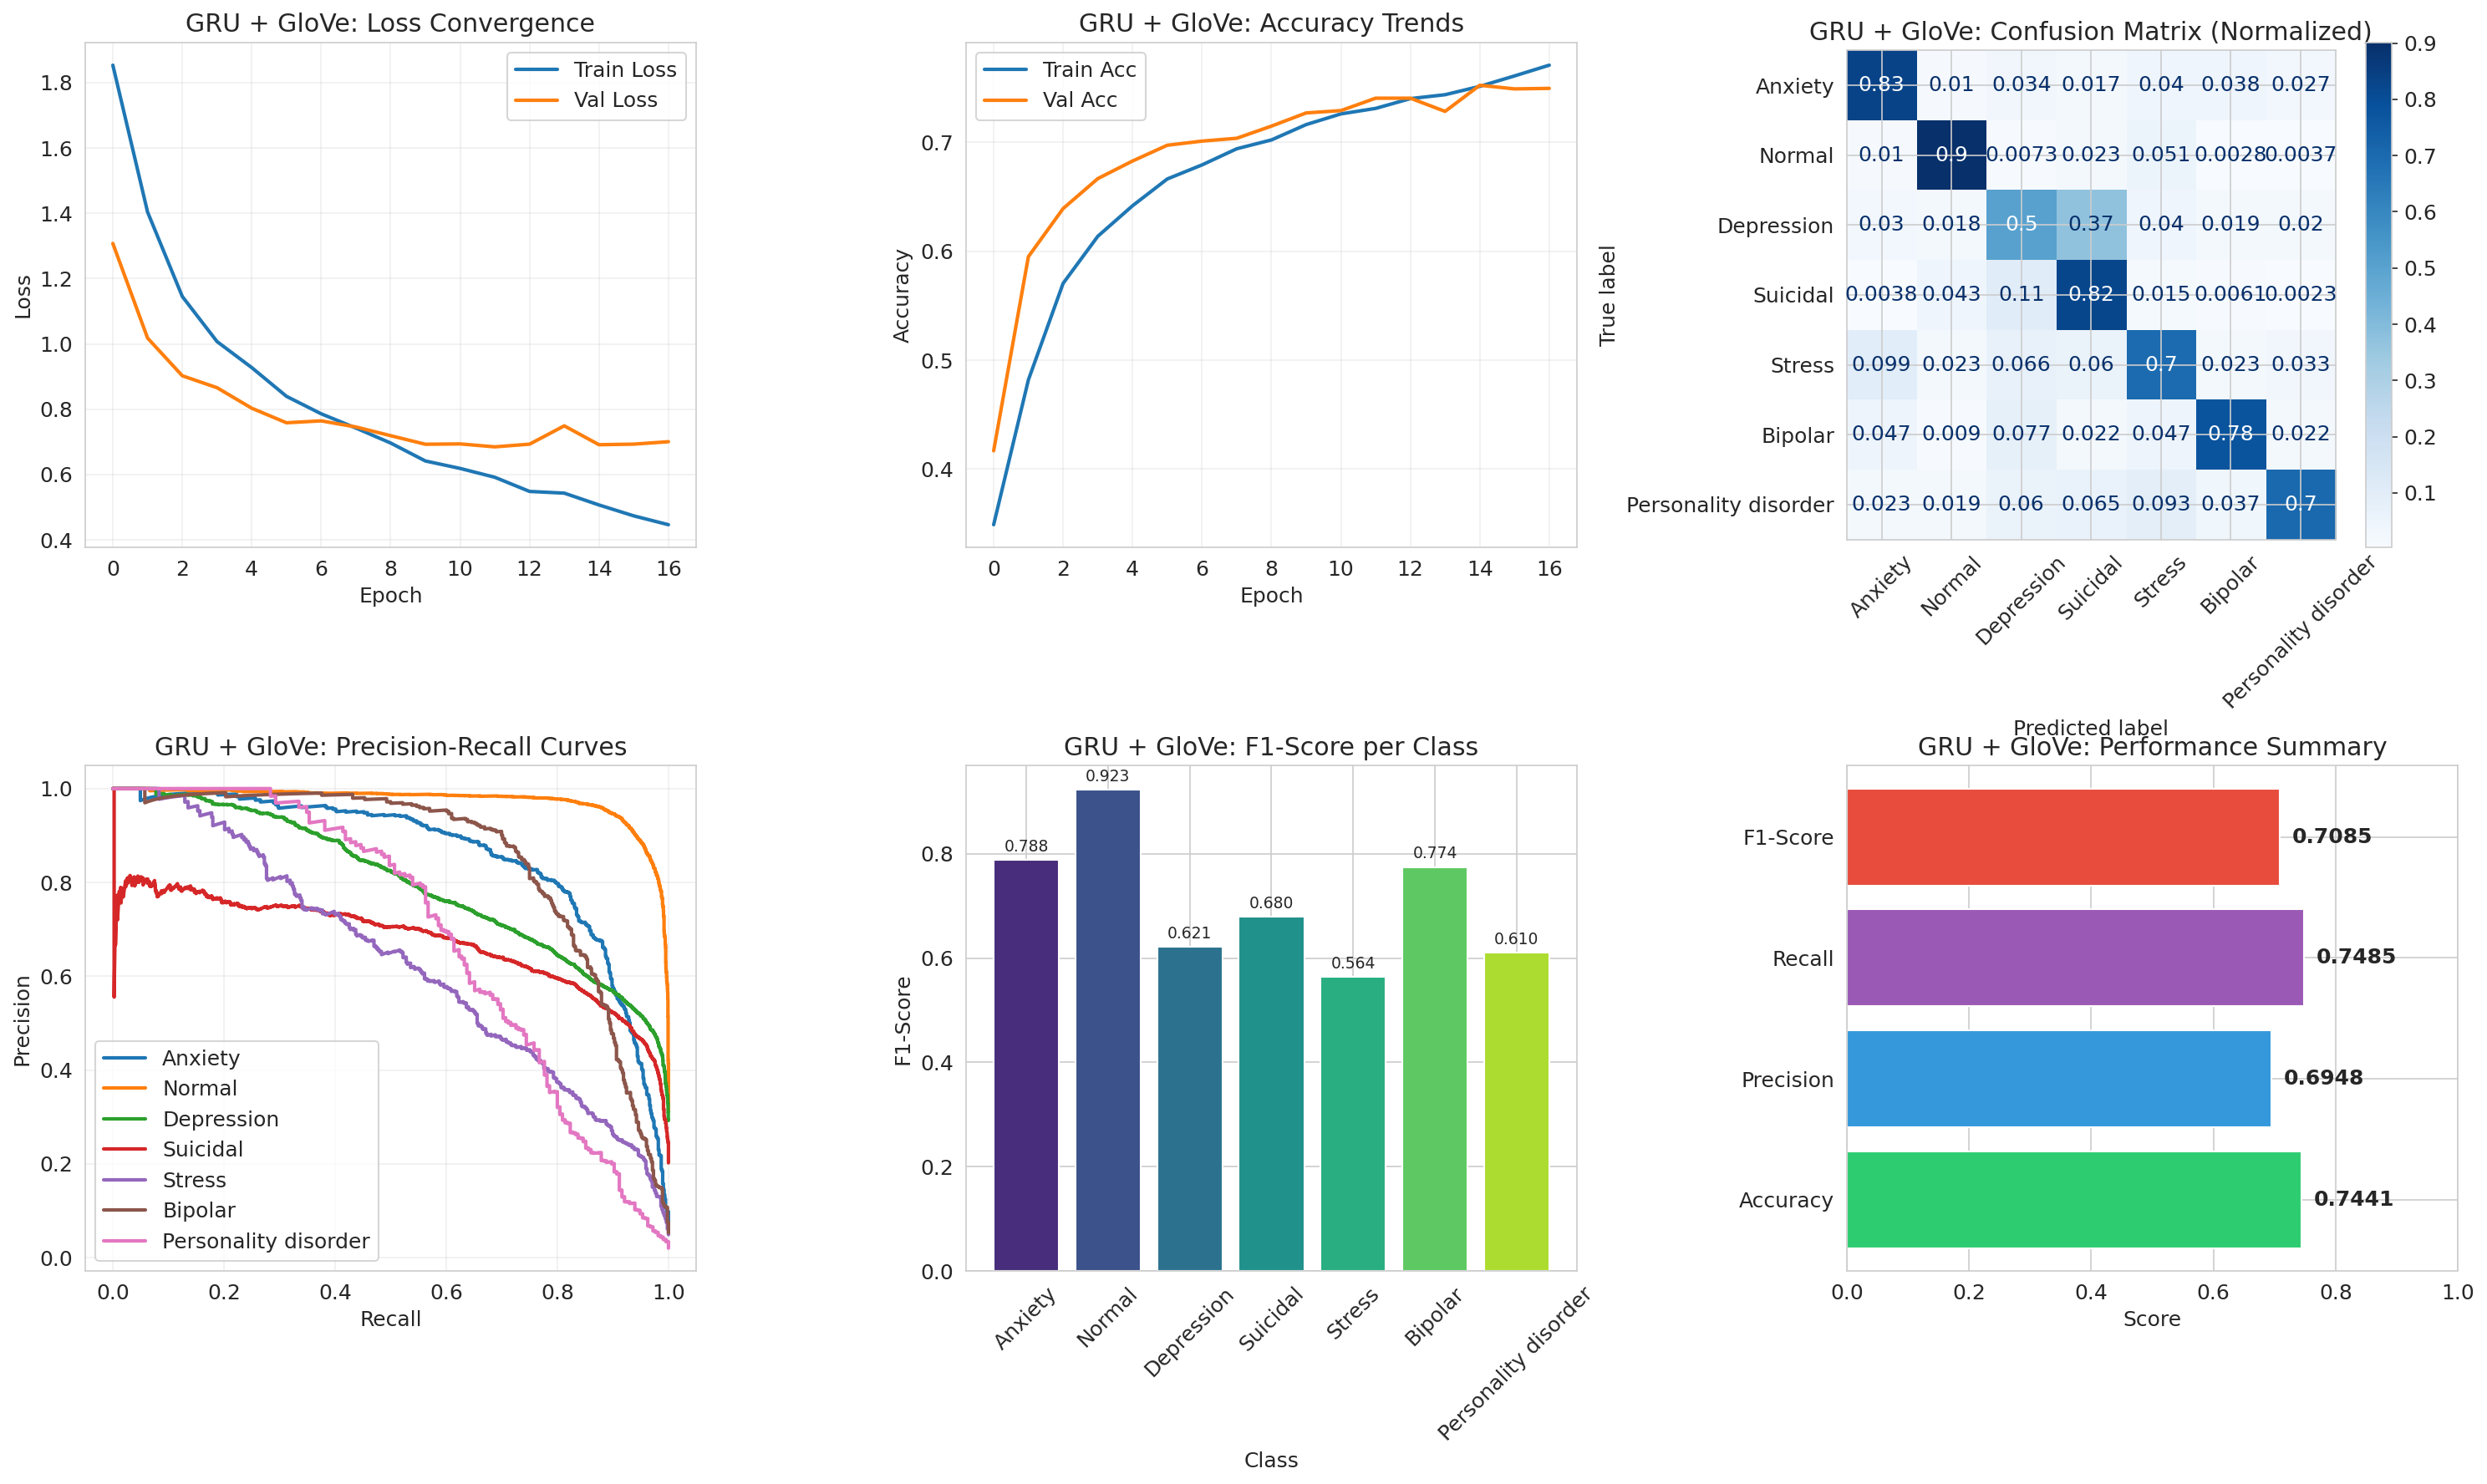

In [30]:
# --- Evaluate GRU + GloVe ---
results_glove = evaluate_model(
    gru_glove_model, X_test_glove, y_test,
    label_map, "GRU + GloVe", history_glove
)

## 6. Comparative Analysis

Comprehensive comparison of GRU performance across all three embedding techniques.

In [31]:
# =====================================================
# COMPARATIVE ANALYSIS
# =====================================================

# Collect all results
all_results = [results_tfidf, results_w2v, results_glove]

# --- Table 1: Performance Metrics Comparison ---
comparison_df = pd.DataFrame({
    'Model': [r['model_name'] for r in all_results],
    'Accuracy': [r['accuracy'] for r in all_results],
    'Precision (Macro)': [r['precision'] for r in all_results],
    'Recall (Macro)': [r['recall'] for r in all_results],
    'F1-Score (Macro)': [r['f1_score'] for r in all_results]
})

# Sort by F1-Score
comparison_df = comparison_df.sort_values('F1-Score (Macro)', ascending=False)

print("="*80)
print("📊 TABLE 1: GRU PERFORMANCE COMPARISON ACROSS EMBEDDINGS")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

📊 TABLE 1: GRU PERFORMANCE COMPARISON ACROSS EMBEDDINGS
                     Model  Accuracy  Precision (Macro)  Recall (Macro)  F1-Score (Macro)
GRU + Word2Vec (Skip-gram)  0.744614           0.699627        0.747271          0.711871
               GRU + GloVe  0.744140           0.694795        0.748474          0.708514
              GRU + TF-IDF  0.710734           0.622771        0.719279          0.650197


In [32]:
# --- Table 2: Per-Class F1-Score Comparison ---
per_class_f1 = {}
for result in all_results:
    model_name = result['model_name']
    report = classification_report(y_test, result['y_pred'], output_dict=True)
    per_class_f1[model_name] = {}
    for class_name, class_idx in label_map.items():
        per_class_f1[model_name][class_name] = report[str(class_idx)]['f1-score']

per_class_df = pd.DataFrame(per_class_f1).T

print("\n" + "="*80)
print("📊 TABLE 2: PER-CLASS F1-SCORE COMPARISON")
print("="*80)
print(per_class_df.to_string())
print("="*80)


📊 TABLE 2: PER-CLASS F1-SCORE COMPARISON
                             Anxiety    Normal  Depression  Suicidal    Stress   Bipolar  Personality disorder
GRU + TF-IDF                0.724604  0.899421    0.594338  0.656684  0.496314  0.737105              0.442916
GRU + Word2Vec (Skip-gram)  0.794677  0.914805    0.639954  0.679669  0.561814  0.775439              0.616740
GRU + GloVe                 0.788177  0.922547    0.621200  0.679559  0.563821  0.774194              0.610101


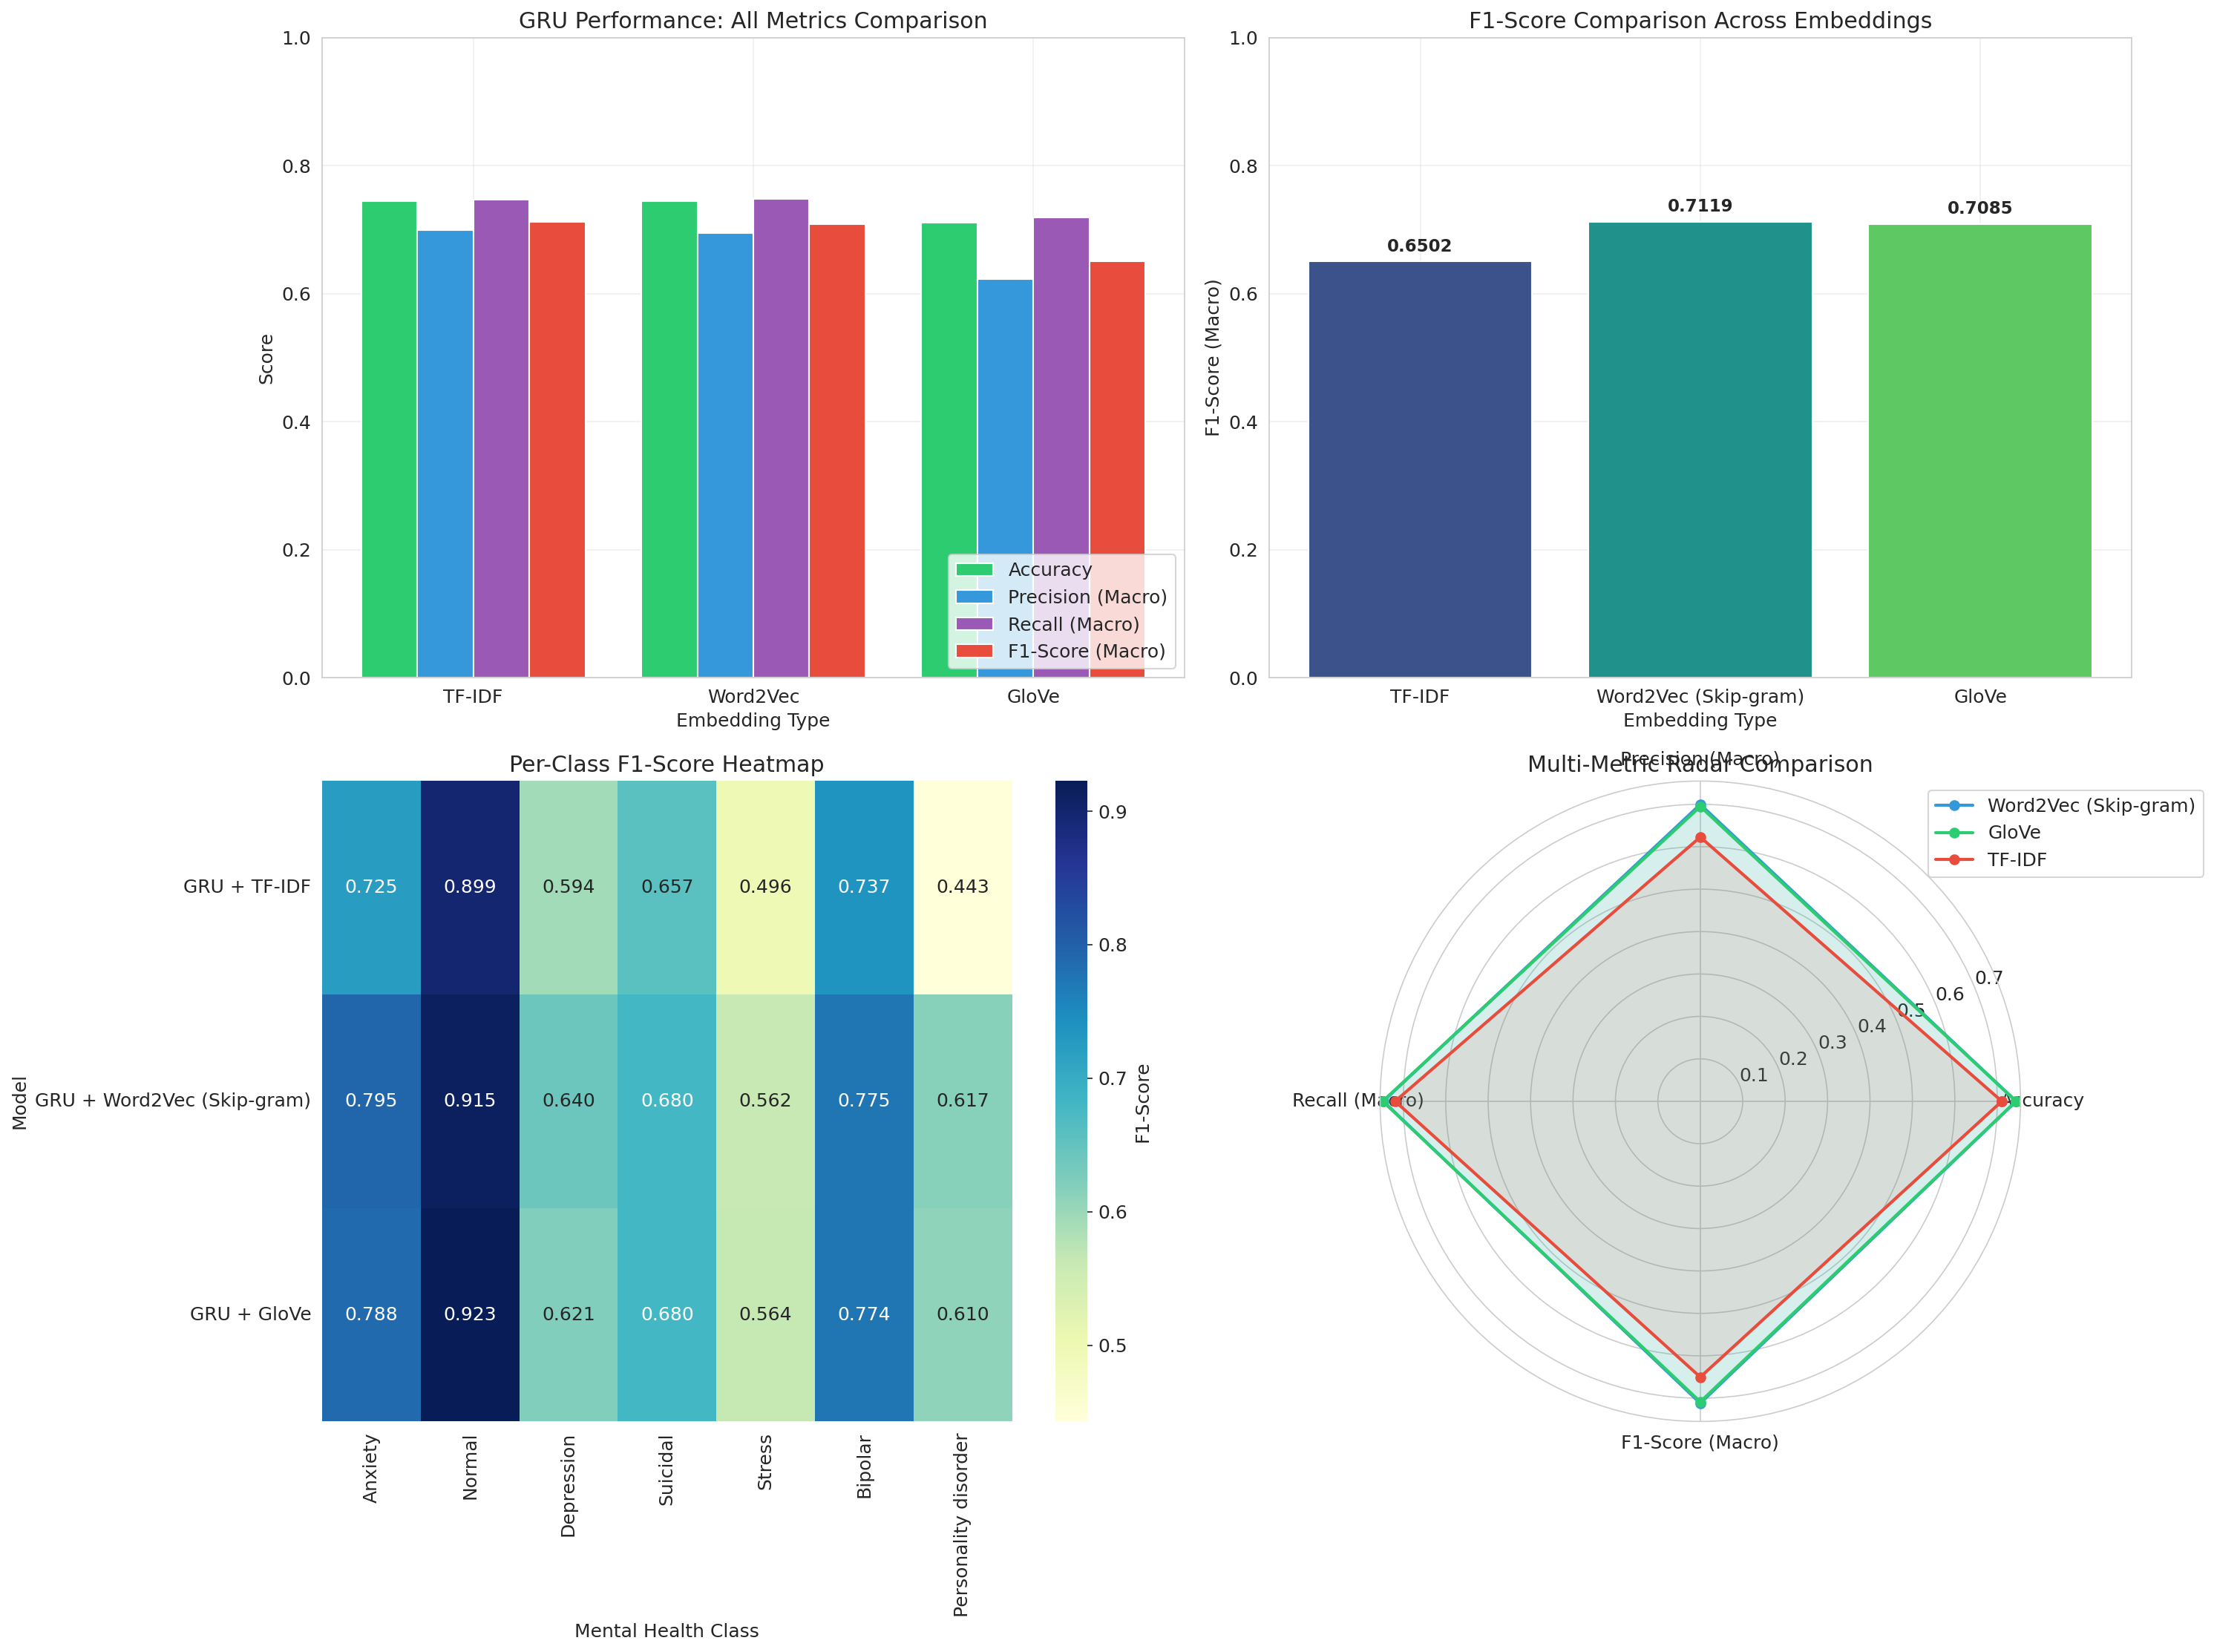

In [33]:
# --- Visualization: Comprehensive Comparison ---
fig = plt.figure(figsize=(20, 15))

# 1. Overall Metrics Comparison
ax1 = fig.add_subplot(2, 2, 1)
x = np.arange(len(comparison_df))
width = 0.2

metrics = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

for i, metric in enumerate(metrics):
    bars = ax1.bar(x + i*width, comparison_df[metric], width, label=metric, color=colors[i])

ax1.set_xlabel('Embedding Type')
ax1.set_ylabel('Score')
ax1.set_title('GRU Performance: All Metrics Comparison')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(['TF-IDF', 'Word2Vec', 'GloVe'], rotation=0)
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# 2. F1-Score Comparison (Bar Chart)
ax2 = fig.add_subplot(2, 2, 2)
model_names = [r['model_name'].replace('GRU + ', '') for r in all_results]
f1_scores = [r['f1_score'] for r in all_results]
bars = ax2.bar(model_names, f1_scores, color=sns.color_palette('viridis', 3))
ax2.set_xlabel('Embedding Type')
ax2.set_ylabel('F1-Score (Macro)')
ax2.set_title('F1-Score Comparison Across Embeddings')
ax2.set_ylim(0, 1)
for bar, score in zip(bars, f1_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Per-Class F1-Score Heatmap
ax3 = fig.add_subplot(2, 2, 3)
sns.heatmap(per_class_df, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax3,
            cbar_kws={'label': 'F1-Score'})
ax3.set_title('Per-Class F1-Score Heatmap')
ax3.set_xlabel('Mental Health Class')
ax3.set_ylabel('Model')

# 4. Radar Chart for Multi-Metric Comparison
ax4 = fig.add_subplot(2, 2, 4, projection='polar')

categories = metrics
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

colors_radar = ['#e74c3c', '#3498db', '#2ecc71']
for idx, row in comparison_df.iterrows():
    values = [row['Accuracy'], row['Precision (Macro)'], row['Recall (Macro)'], row['F1-Score (Macro)']]
    values += values[:1]
    model_label = row['Model'].replace('GRU + ', '')
    ax4.plot(angles, values, 'o-', linewidth=2, label=model_label, color=colors_radar[idx % 3])
    ax4.fill(angles, values, alpha=0.1, color=colors_radar[idx % 3])

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories)
ax4.set_title('Multi-Metric Radar Comparison')
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('gru_comparative_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

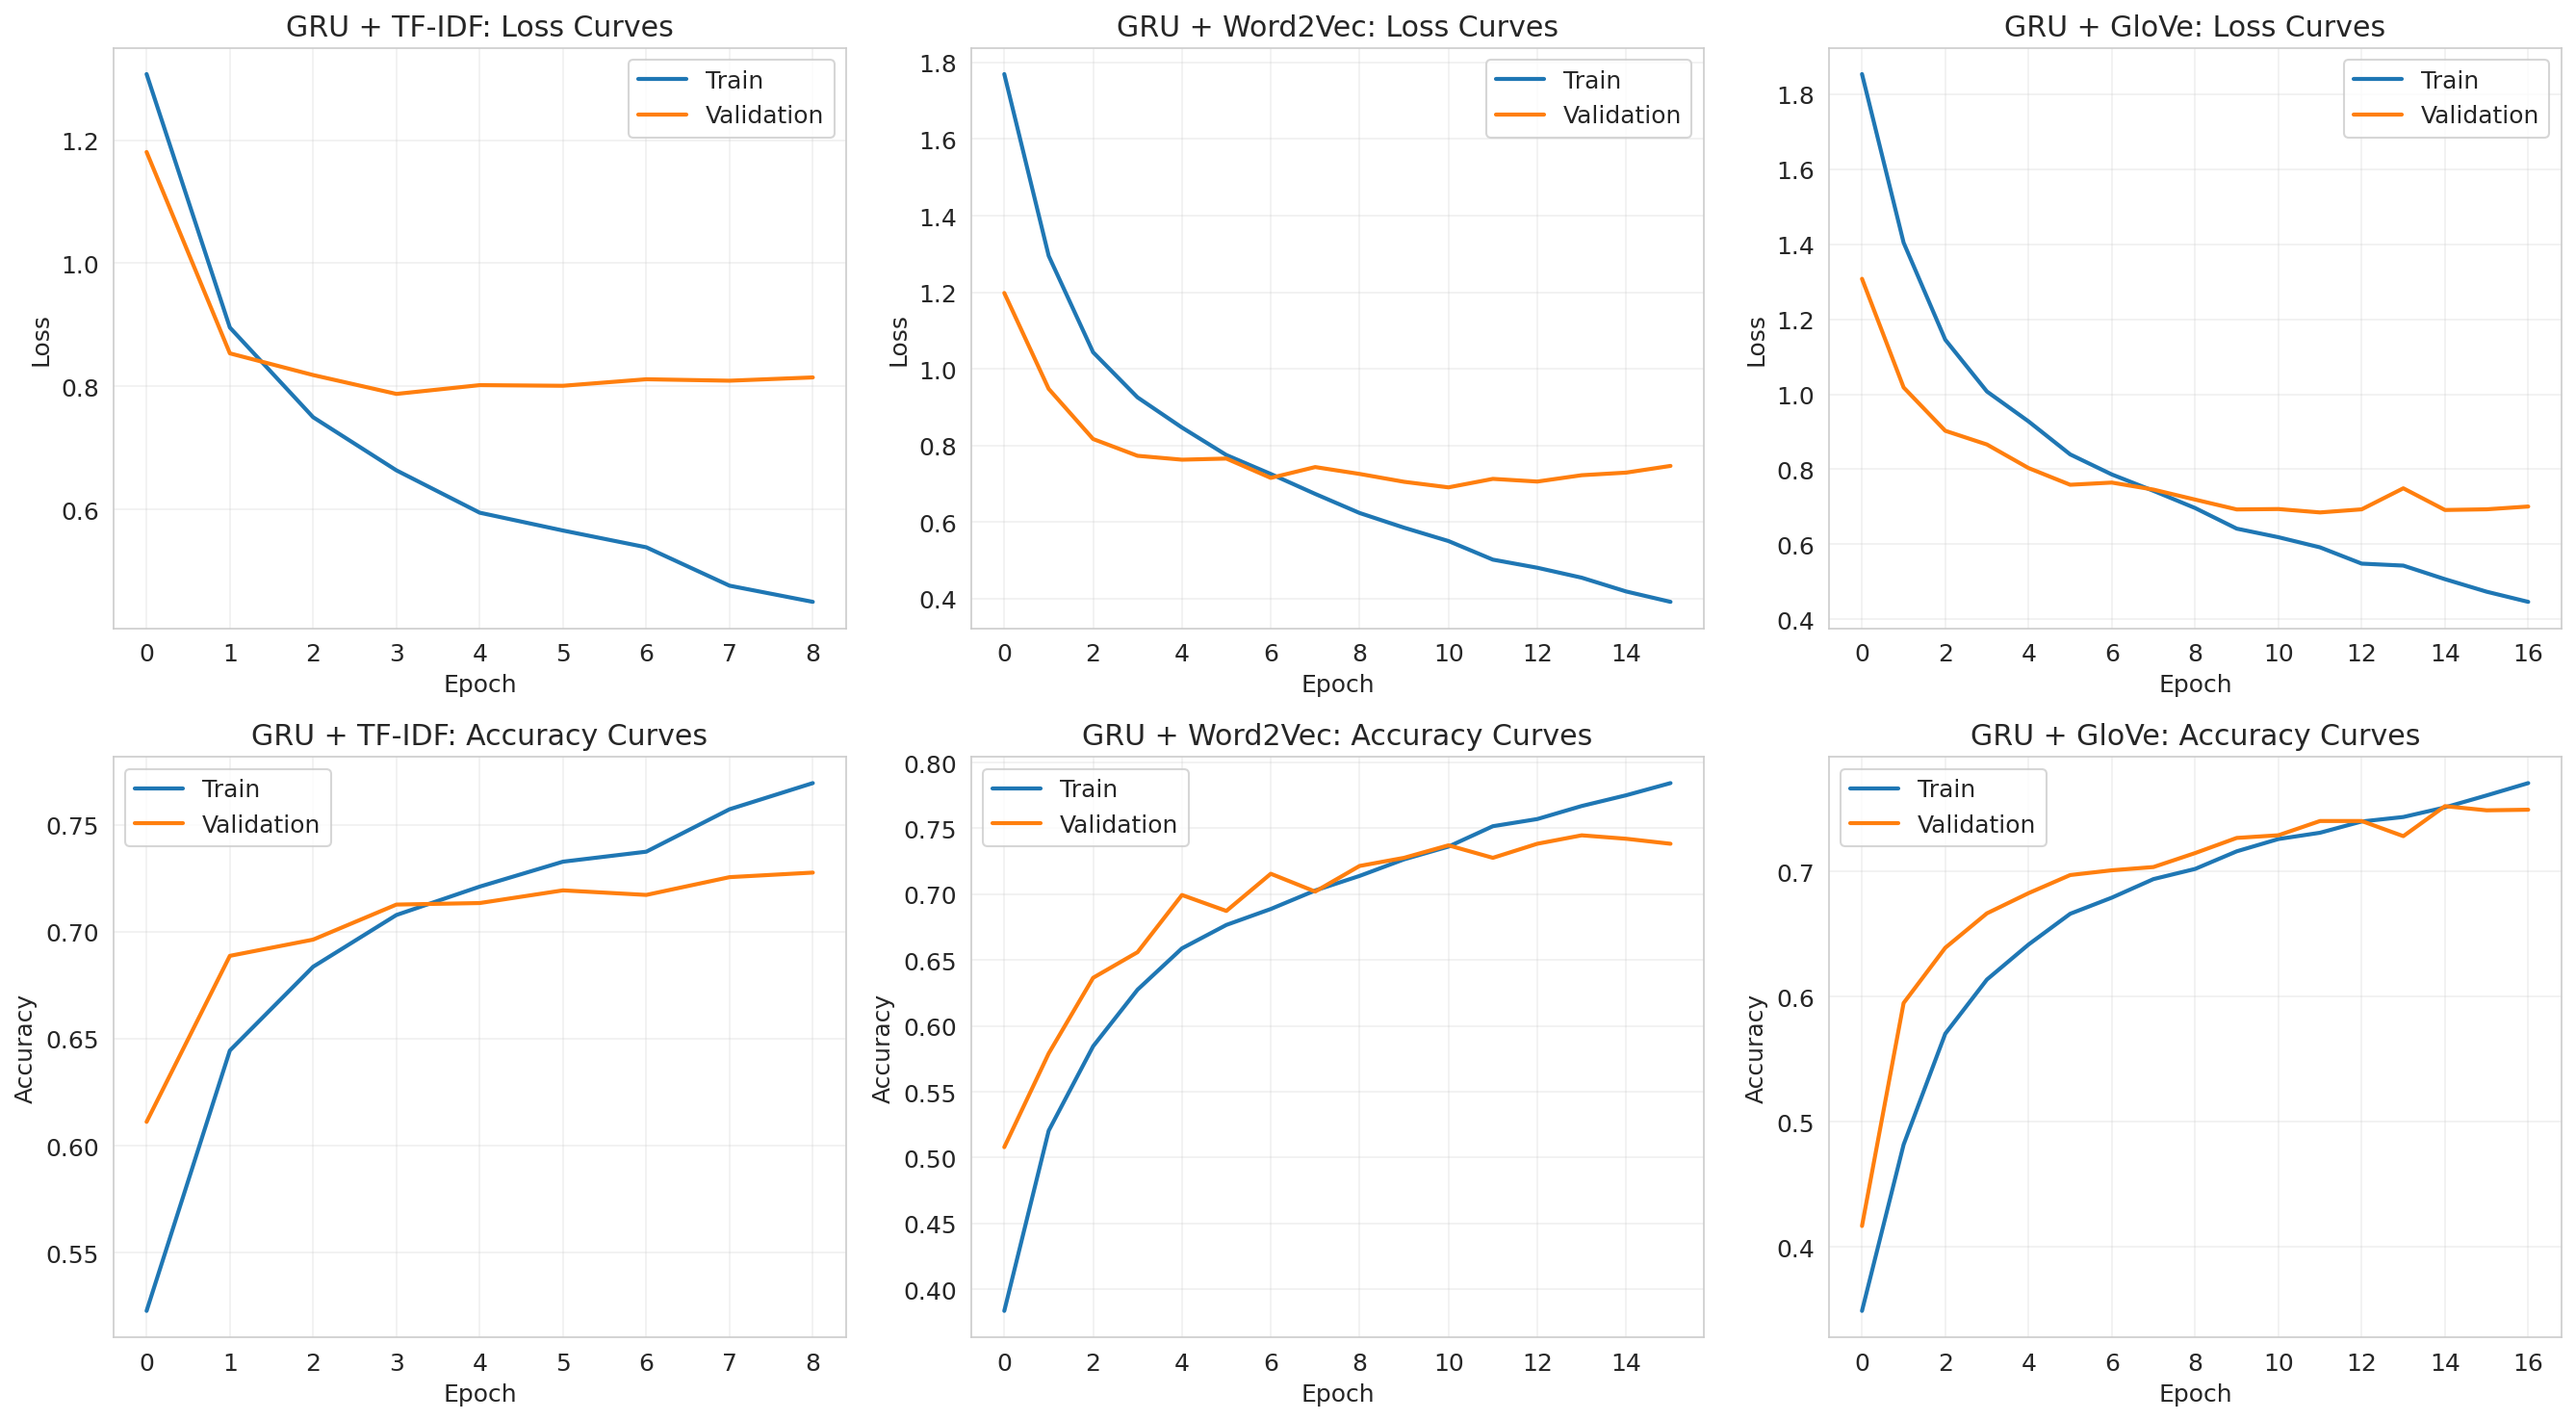

In [34]:
# --- Learning Curves Comparison ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = [history_tfidf, history_w2v, history_glove]
titles = ['GRU + TF-IDF', 'GRU + Word2Vec', 'GRU + GloVe']

for idx, (history, title) in enumerate(zip(histories, titles)):
    # Loss curves
    axes[0, idx].plot(history.history['loss'], label='Train', linewidth=2)
    axes[0, idx].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].set_title(f'{title}: Loss Curves')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)

    # Accuracy curves
    axes[1, idx].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[1, idx].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Accuracy')
    axes[1, idx].set_title(f'{title}: Accuracy Curves')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gru_learning_curves_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

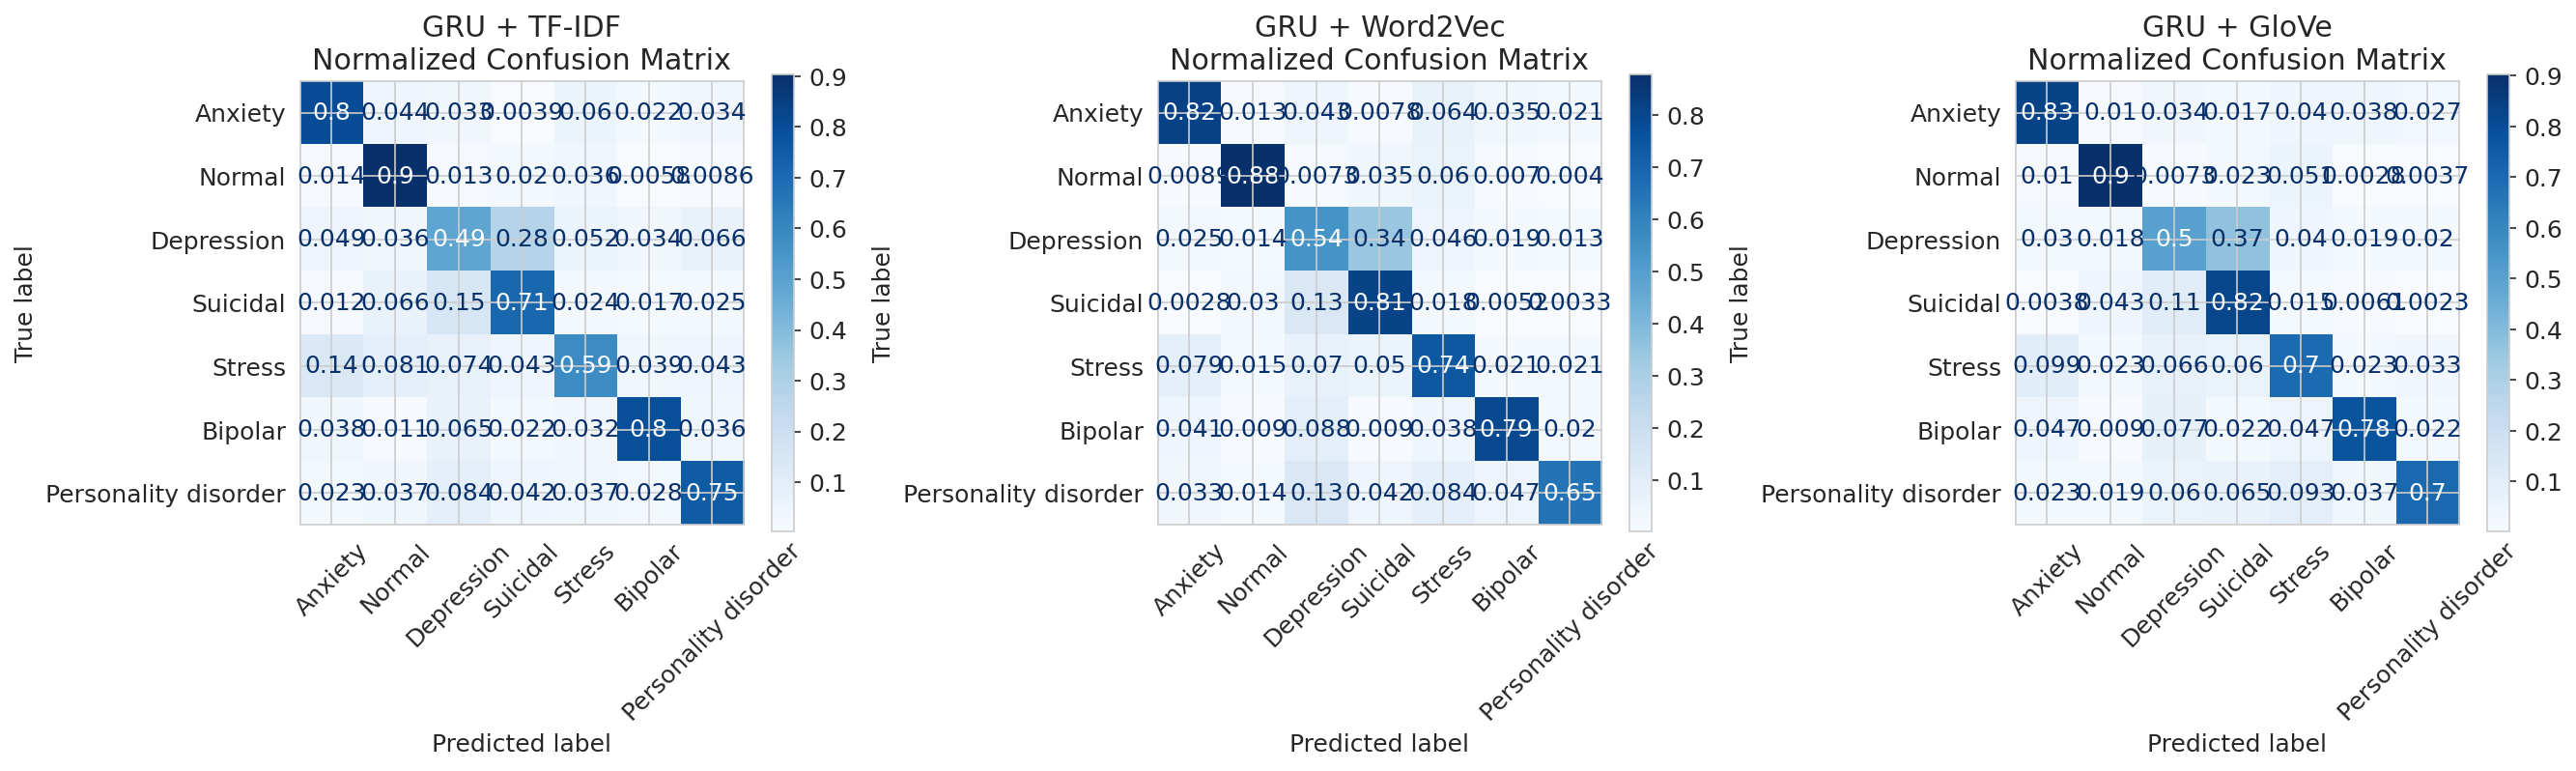

In [35]:
# --- Confusion Matrices Side by Side ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (result, title) in enumerate(zip(all_results, titles)):
    cm = confusion_matrix(y_test, result['y_pred'], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
    disp.plot(cmap='Blues', ax=axes[idx], xticks_rotation=45)
    axes[idx].set_title(f'{title}\nNormalized Confusion Matrix')

plt.tight_layout()
plt.savefig('gru_confusion_matrices_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [36]:
# --- Save Results to CSV ---
comparison_df.to_csv('gru_embedding_comparison_results.csv', index=False)
per_class_df.to_csv('gru_per_class_f1_scores.csv')

print("\n✅ Results saved to:")
print("  - gru_embedding_comparison_results.csv")
print("  - gru_per_class_f1_scores.csv")


✅ Results saved to:
  - gru_embedding_comparison_results.csv
  - gru_per_class_f1_scores.csv


## 7. Analysis & Conclusions

### Summary of Findings

In [37]:
# --- Final Summary ---
print("="*80)
print("📊 FINAL SUMMARY: GRU MODEL WITH MULTIPLE EMBEDDINGS")
print("="*80)

best_model = comparison_df.iloc[0]
print(f"\n🏆 BEST PERFORMING MODEL: {best_model['Model']}")
print(f"   Accuracy:  {best_model['Accuracy']:.4f}")
print(f"   Precision: {best_model['Precision (Macro)']:.4f}")
print(f"   Recall:    {best_model['Recall (Macro)']:.4f}")
print(f"   F1-Score:  {best_model['F1-Score (Macro)']:.4f}")

print("\n" + "-"*80)
print("KEY OBSERVATIONS:")
print("-"*80)
print("""
1. EMBEDDING COMPARISON:
   - TF-IDF: Captures document-level importance but lacks semantic relationships
   - Word2Vec (Skip-gram): Captures local context and semantic similarity
   - GloVe: Combines global statistics with local context

2. GRU ARCHITECTURE BENEFITS:
   - Simpler than LSTM with fewer parameters
   - Effective for shorter sequences (mental health statements)
   - Bidirectional configuration captures both past and future context

3. MENTAL HEALTH CLASSIFICATION INSIGHTS:
   - Class imbalance affects minority class performance
   - Emotionally charged words are important features
   - Context preservation (negation handling) improves results

4. RECOMMENDATIONS:
   - Use pre-trained embeddings (GloVe/Word2Vec) for better generalization
   - Fine-tune embeddings on domain-specific data
   - Consider ensemble methods for improved performance
""")
print("="*80)

📊 FINAL SUMMARY: GRU MODEL WITH MULTIPLE EMBEDDINGS

🏆 BEST PERFORMING MODEL: GRU + Word2Vec (Skip-gram)
   Accuracy:  0.7446
   Precision: 0.6996
   Recall:    0.7473
   F1-Score:  0.7119

--------------------------------------------------------------------------------
KEY OBSERVATIONS:
--------------------------------------------------------------------------------

1. EMBEDDING COMPARISON:
   - TF-IDF: Captures document-level importance but lacks semantic relationships
   - Word2Vec (Skip-gram): Captures local context and semantic similarity
   - GloVe: Combines global statistics with local context

2. GRU ARCHITECTURE BENEFITS:
   - Simpler than LSTM with fewer parameters
   - Effective for shorter sequences (mental health statements)
   - Bidirectional configuration captures both past and future context

3. MENTAL HEALTH CLASSIFICATION INSIGHTS:
   - Class imbalance affects minority class performance
   - Emotionally charged words are important features
   - Context preservation (

In [38]:
# --- Hyperparameter Summary Table ---
hyperparams_summary = pd.DataFrame({
    'Parameter': ['Embedding Dimension', 'Max Sequence Length', 'GRU Units',
                  'Dropout Rate', 'Recurrent Dropout', 'Dense Units',
                  'Learning Rate', 'Batch Size', 'Max Epochs'],
    'TF-IDF': ['5000 (features)', '1', '128', '0.5', '0.2', '64', '0.001', '64', '30'],
    'Word2Vec': ['100', '100', '128', '0.5', '0.2', '64', '0.001', '64', '30'],
    'GloVe': ['100', '100', '128', '0.5', '0.2', '64', '0.001', '64', '30']
})

print("\n" + "="*80)
print("📋 HYPERPARAMETER CONFIGURATION SUMMARY")
print("="*80)
print(hyperparams_summary.to_string(index=False))
print("="*80)


📋 HYPERPARAMETER CONFIGURATION SUMMARY
          Parameter          TF-IDF Word2Vec GloVe
Embedding Dimension 5000 (features)      100   100
Max Sequence Length               1      100   100
          GRU Units             128      128   128
       Dropout Rate             0.5      0.5   0.5
  Recurrent Dropout             0.2      0.2   0.2
        Dense Units              64       64    64
      Learning Rate           0.001    0.001 0.001
         Batch Size              64       64    64
         Max Epochs              30       30    30


---

## References

1. Cho, K., et al. (2014). Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation. *EMNLP*.

2. Mikolov, T., et al. (2013). Distributed Representations of Words and Phrases and their Compositionality. *NIPS*.

3. Pennington, J., Socher, R., & Manning, C. (2014). GloVe: Global Vectors for Word Representation. *EMNLP*.

4. Zhang, Y., & Wallace, B. (2015). A Sensitivity Analysis of Convolutional Neural Networks for Sentence Classification. *IJCNLP*.

---

**End of Notebook**